# **Skin Lesion CADx Challenge: PART I - Classical**


Authors: Rachika Elhasna HAMADACHE & Kaouther MOUHEB

In this notebook, we will solve the first part of the CADx project on Skin Lesion Classification using Classical Approaches. This notebook will cover the first challenge: Binary Classification: Nevus VS Others 


## Connect to Google Drive 

* *Mount Drive*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
# Install libraries that are not availabel in colab
!pip install mahotas
!pip install mlxtend
!pip install xgboost
!pip install plantcv
!pip install scikit-image --upgrade

In [3]:
##################################     GENERAL     ###########################################
import math
import time
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy.ma as ma
from tabulate import tabulate
import os
import mahotas  
import pickle
import seaborn as sns

################################## Computer Vision ###########################################
import cv2 as cv
from PIL import Image
from scipy import ndimage
from scipy.spatial.distance import dice
from scipy.ndimage import gaussian_filter
from skimage import data, morphology
from skimage.measure import label, regionprops
from skimage.color import rgb2lab, lab2rgb
from skimage.filters import threshold_multiotsu, threshold_otsu
from skimage.morphology import skeletonize
from plantcv import plantcv as pcv
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops


################################## MACHINE LEARNING  ###########################################
import sklearn as sk
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, balanced_accuracy_score 
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.feature_selection import SelectKBest, SelectFromModel

#models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier
from sklearn import linear_model
import xgboost as xgb

## Utils

### Preprocessing helper functions

In this section we define helper funtions to be used in the preprocessing pipelines

#### 0. Reading image

In [4]:
def read_img(img_id: str, set_: str):
    '''
    read a raw image from the dataset folders
    Args:
    - img_id (string): image folder name (without extension)
    - set_ (string): train or validation
    Return:
    - The RGB raw image stored in a numpy ndarray.
    '''
    if img_id[0:3] == "nev":
      path = f"/content/drive/MyDrive/CAD_Dataset/Challenge1/{set_}/{set_}/nevus/{img_id}.jpg"

    else:
      path = f"/content/drive/MyDrive/CAD_Dataset/Challenge1/{set_}/{set_}/others/{img_id}.jpg"
    # read the image 
    img = cv.imread(path) 
    # convertfrom RGB to BGR
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
    return img_rgb

In [5]:
def read_img_prepro(img_id: str, set_:str):
  '''
    read a preprocessed image from the dataset folders
    Args:
    - img_id (string): image folder name (without extension)
    - set_ (string): train or validation
    Return:
    - The RGB preprocessed image stored in a numpy ndarray.
  '''
  path = f"/content/drive/MyDrive/CAD_Dataset/Challenge1/preprocessed/{set_}/{img_id}.jpg"
  img = cv.imread(path)
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  return img_rgb

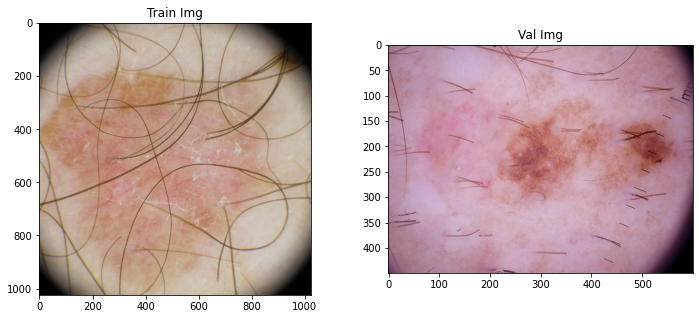

In [6]:
#### Function Test #### 
img_id = "ack00024"
img_train = read_img(img_id, "train")


img_id = "bkl01762"
img_val = read_img(img_id, "val")


fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12, 5))

axes[0].imshow(img_train)
axes[0].set_title('Train Img')
         
axes[1].imshow(img_val)
axes[1].set_title('Val Img')

plt.subplots_adjust()
plt.show()


#### 1. Vignette removal

In [7]:
def crop_img(img: np.ndarray, threshold: int=50):
    '''
    Crop the image to get the region of interest. Remove the vignette frame.
    Analyze the value of the pixels in the diagonal of the image, from 0,0 to h,w and
    take the points where this value crosses the threshold by the first time and for last.
    Args:
    - img (numpy ndarray): Image to crop.
    - threshold (int): Value to split the diagonal into image and frame.
    Return:
    - The coordinates of the rectangle and the cropped image.
    '''
    # Get the image dimensions
    h, w = img.shape[:2]
    cd = math.gcd(h, w)  # Greatest Common Divider

    # Get the coordinates of the pixels in the diagonal
    y_coords = ([i for i in range(0, h, int(h/cd))], [i for i in range(h - int(h/cd), 0, -int(h/cd))])
    x_coords = ([i for i in range(0, w, int(w/cd))], [i for i in range(0, w, int(w/cd))])

    # Get the mean value of the pixels in the diagonal, form 0,0 to h,w 
    # and from h,0 to 0,w
    coordinates = {'y1_1': 0, 'x1_1': 0, 'y2_1': h, 'x2_1': w, 'y1_2': h, 'x1_2': 0, 'y2_2': 0, 'x2_2': w}
    for i in range(2):
        d = []
        y1_aux, x1_aux = 0, 0
        y2_aux, x2_aux = h, w 
        for y, x in zip(y_coords[i], x_coords[i]):
            d.append(np.mean(img[y, x, :]))

        # Get the location of the first point where the threshold is crossed
        for idx, value in enumerate(d):
            if (value >= threshold and idx != 0):  # If there's no vignette, in idx=0 the value would be > thresh..
                coordinates['y1_' + str(i + 1)] = y_coords[i][idx]
                coordinates['x1_' + str(i + 1)] = x_coords[i][idx]
                break

        # Get the location of the last point where the threshold is crossed
        for idx, value in enumerate(reversed(d)):
            if (value >= threshold and idx != 0):  # If there's no vignette, in idx=0 the value would be > thresh..
                coordinates['y2_' + str(i + 1)] = y_coords[i][len(y_coords[i])-idx]
                coordinates['x2_' + str(i + 1)] = x_coords[i][len(x_coords[i])-idx]
                break

    # Set the coordinates to crop the image
    y1 = max(coordinates['y1_1'], coordinates['y2_2'])
    y2 = min(coordinates['y2_1'], coordinates['y1_2'])
    x1 = max(coordinates['x1_1'], coordinates['x1_2'])
    x2 = min(coordinates['x2_1'], coordinates['x2_2'])

    img_new = img[y1:y2, x1:x2, :]

    if img_new.shape[0] == 0 or img_new.shape[1] == 0:
      img_new = img 
    
    return img_new  #y1, y2, x1, x2, img[y1:y2, x1:x2, :]

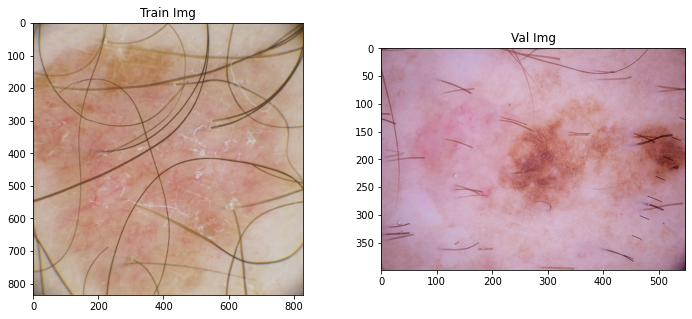

In [8]:
#### Function Test #### 

img_train_crop = crop_img(img_train)
img_val_crop = crop_img(img_val)


fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12, 5))

axes[0].imshow(img_train_crop)
axes[0].set_title('Train Img')
         
axes[1].imshow(img_val_crop)
axes[1].set_title('Val Img')

plt.subplots_adjust()
plt.show()

#### 2. Hair Removal

In [9]:
def inpaint(src: np.ndarray, se_size: int = 15):    
    '''param : src --> Color image
               se_size --> Size of the structuring elements
      return : Inp --> Inpainted image with hair removed '''

    # Convert the original image to grayscale if it has > 1 channel
    if (len(src.shape)==3):
      channel = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    else:
      channel = src

    # Structuring Element for the morphological filtering
    
    se = cv.getStructuringElement(1, (se_size, se_size))  # (17x17) '+' shaped SE
    se2 = np.array(list(reversed(list(zip(*np.eye(se_size)))))) + np.eye(se_size)
    se2[int(se_size/2), int(se_size/2)] = 1  # (17x17) 'X' shaped SE
    
    # Perform the blackHat filtering on the grayscale image to find the 
    # hair (and other objects') countours
    blackhat = cv.morphologyEx(channel, cv.MORPH_BLACKHAT, se)
    blackhat2 = cv.morphologyEx(channel, cv.MORPH_BLACKHAT, se2.astype(np.uint8))
    bHat = blackhat + blackhat2

    # Intensify the countours detected in preparation for the inpainting algorithm
    ret, thresh = cv.threshold(bHat, 10, 255, cv.THRESH_BINARY)

    # Inpaint the original image depending on the mask
    Inp = cv.inpaint(src, thresh, 1, cv.INPAINT_TELEA)

    return Inp

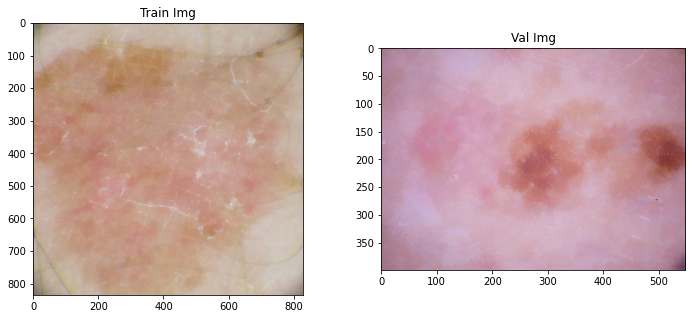

In [10]:
#### Function Test #### 

img_train_inp = inpaint(img_train_crop)
img_val_inp = inpaint(img_val_crop)


fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12, 5))

axes[0].imshow(img_train_inp)
axes[0].set_title('Train Img')
         
axes[1].imshow(img_val_inp)
axes[1].set_title('Val Img')

plt.subplots_adjust()
plt.show()

#### 3. Color Constancy 

In [12]:
def shade_of_gray_cc(img: np.ndarray, power:int =6, gamma=None):
    """
    function to normalize the colors of an image using the shades of gray algorithm
    args:
      - img (numpy array): the original image with format of (h, w, c)
      - power (int): the degree of norm, 6 is used in reference paper
      - gamma (float): the value of gamma correction, 2.2 is used in reference paper

    return: image after color normalization
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)

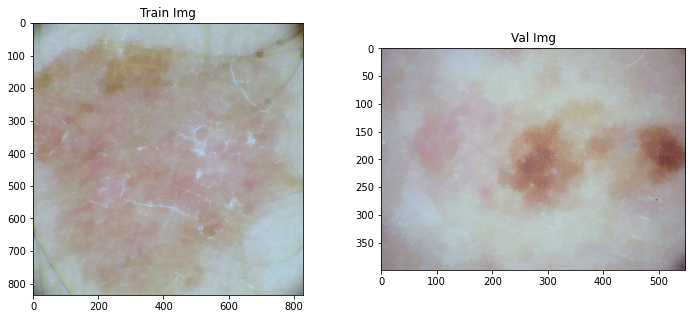

In [13]:
#### Function Test #### 
img_train_cc = shade_of_gray_cc(img_train_inp)
img_val_cc = shade_of_gray_cc(img_val_inp)


fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12, 5))

axes[0].imshow(img_train_cc)
axes[0].set_title('Train Img')
         
axes[1].imshow(img_val_cc)
axes[1].set_title('Val Img')

plt.subplots_adjust()
plt.show()

#### 4. Other

In [15]:
def resize_im(img: np.ndarray, max_size: int):  
  '''
    function to resize an image while maintaining the aspect ratio
    args: 
      - img: (np.ndarray) image to be resized 
      - max_size: the new size of the largest side of the image
  ''' 
  scale_percent = round((max_size / max(img.shape[0], img.shape[1])),2) 
  width = int(img.shape[1] * scale_percent)
  height = int(img.shape[0] * scale_percent)
  dim = (width, height)
  # Resize image
  image = cv.resize(img, dim, interpolation = cv.INTER_CUBIC)
  return image


In [16]:
###### Test function #############
resized = resize_im(img_train, 500);

print(f"Before: {img_train.shape}\nAfter: {resized.shape}")

Before: (1024, 1024, 3)
After: (501, 501, 3)


Preprocessing function:

In [19]:
def preprocess(img: np.ndarray, max_size: int, crop_params=None, cc_params=None, remove_hair_params=None):
    '''
        function that runs the whole preprocessing pipeline over an image 
        args:
          - img: (np.ndarray) image to be processed 
          - img_size: (int) new image sizes
          - crop_params: (dict) parameters of cropping function stored in a dict
          - cc_params: (dict) parameters of color normalization function stored in a dict
          - remove_hair_params: (dict) parameters of hair removal function stored in a dict
    returns: the preprocessed image stored in an ndarray
      '''
    if crop_params is not None:
      img = crop_img(img, threshold=crop_params["threshold"])

    img = resize_im(img, max_size)

    if cc_params is not None: 
      img = shade_of_gray_cc(img, power=cc_params["power"], gamma=cc_params["gamma"])

    if remove_hair_params is not None: 
      img = inpaint(img, se_size =  remove_hair_params['se_size'])

    return img

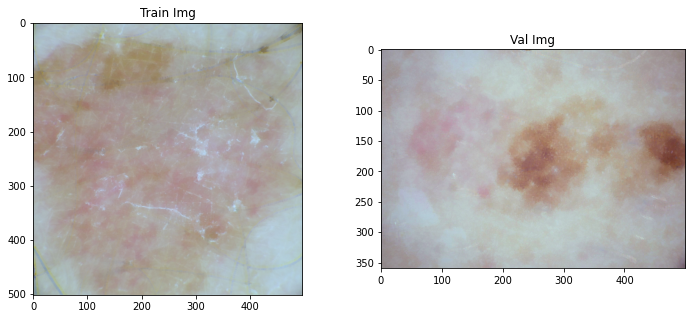

In [20]:
#### Function Test #### 
img_train_pp = preprocess(img_train, 500, crop_params= {"threshold": 100}, cc_params={"gamma": None, "power":6}, remove_hair_params={'se_size': 9})
img_val_pp = preprocess(img_val, 500, crop_params= {"threshold": 100}, cc_params={"gamma": None, "power":6}, remove_hair_params={'se_size': 9})


fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12, 5))

axes[0].imshow(img_train_pp)
axes[0].set_title('Train Img')
         
axes[1].imshow(img_val_pp)
axes[1].set_title('Val Img')

plt.subplots_adjust()
plt.show()

### Feature Extraction helper functions

In this section we define helper funtions to be used to extract the different features from the images.

#### Global

Functions that consider the whole image

In [21]:
def variegation(Im: np.ndarray):
  '''param : Im            --> RGB image
    return : C_r, C_g, C_b --> Color Variegation measures for each RGB Channel '''  

  # Split Color channels  
  lesion_r = Im[:, :, 0]
  lesion_g = Im[:, :, 1]
  lesion_b = Im[:, :, 2]

  # Compute the normalized Standard Deviation of each channel
  C_r = np.std(lesion_r) / np.max(lesion_r)
  C_g = np.std(lesion_g) / np.max(lesion_g)
  C_b = np.std(lesion_b) / np.max(lesion_b)

  variegation = np.array([C_r, C_g, C_b]).reshape(1, -1)
  return variegation

In [22]:
### Test function ### 
vari_train = variegation(img_train)
vari_val = variegation(img_val)

print(f"Train: {vari_train}\nValid: {vari_val}")

Train: [[0.20073287 0.19050469 0.18240194]]
Valid: [[0.13631264 0.14599216 0.1486128 ]]


In [23]:
vari_train.shape

(1, 3)

#### Color

Function to extract color features

In [24]:
def color_moments(Img: np.ndarray):
    """ Extract Color Moments of an image.
    --> param Img : ndarray, RGB image
    --> return color_moments : ndarray, contains the 4 Central Color Moments """

    c1, c2, c3 = cv.split(Img)
    color_feature = []  # Initialize the color feature

    # -- The first central moment - average
    c1_mean = np.mean(c1)  # np.sum(h)/float(N)
    c2_mean = np.mean(c2)  # np.sum(s)/float(N)
    c3_mean = np.mean(c3)  # np.sum(v)/float(N)
    color_feature.extend([c1_mean, c2_mean, c3_mean])
    # -- The second central moment - standard deviation
    c1_std = np.std(c1)  # np.sqrt(np.mean(abs(h - h.mean())**2))
    c2_std = np.std(c2)  # np.sqrt(np.mean(abs(s - s.mean())**2))
    c3_std = np.std(c3)  # np.sqrt(np.mean(abs(v - v.mean())**2))
    color_feature.extend([c1_std, c2_std, c3_std])
    # -- The third central moment - the third root of the skewness
    c1_skewness = np.mean(abs(c1 - c1.mean())**3)
    c2_skewness = np.mean(abs(c2 - c2.mean())**3)
    c3_skewness = np.mean(abs(c3 - c3.mean())**3)
    c1_thirdMoment = c1_skewness**(1./3)
    c2_thirdMoment = c2_skewness**(1./3)
    c3_thirdMoment = c3_skewness**(1./3)
    color_feature.extend([c1_thirdMoment, c2_thirdMoment, c3_thirdMoment])
    # -- The fourth central moment - the variance
    c1_var = c1_std**2  # (np.mean(abs(h - h.mean())**2))
    c2_var = c2_std**2  # (np.mean(abs(s - s.mean())**2))
    c3_var = c3_std**2  # (np.mean(abs(v - v.mean())**2))
    color_feature.extend([c1_var, c2_var, c3_var])

    return np.array(color_feature).reshape(1, -1)

In [25]:
### Test function ### 
col_mom_train = color_moments(img_train)
col_mom_val = color_moments(img_val)

print(f"Train: {col_mom_train}\nValid: {col_mom_val}")

Train: [[ 175.26778316  147.43442154  129.36510944   46.16856064   41.91103071
    40.49322977   64.6244997    55.68717133   51.10018245 2131.53599157
  1756.53449494 1639.70165699]]
Valid: [[ 186.62092963  141.35957407  158.01221111   32.57872127   32.26426631
    35.96429653   49.4197009    43.20338065   46.93285543 1061.37307973
  1040.98288056 1293.43062496]]


In [26]:
col_mom_train.shape

(1, 12)

In [30]:
def extract_color_histogram(Img: np.ndarray, n_bins: int=256):
    """Extract Color histogram of an image.
    --> param Img : ndarray, RGB image
    --> return feature : ndarray, contains n_bins*n_bins*n_bins of RGB, HSV & L.a.b histogram features of the image
    """
    # --- RGB : ---
    rgb_ft = []
    channels = cv.split(Img)
    colors = ("r", "g", "b")
    for (channel, color) in zip(channels, colors):  
      hist = cv.calcHist([channel], [0], None, [n_bins], [1, 256])     # For each image channel, the normalized histogram is computed
      hist = hist/hist.sum()
      #cv.normalize(hist, hist, norm_type=cv.NORM_MINMAX)
      rgb_ft.extend(hist)  
    rgb_ft = np.array(rgb_ft).reshape(1, -1)

    # --- HSV : ---
    hsv_ft = []
    hsv = cv.cvtColor(Img, cv.COLOR_RGB2HSV) # Convert the image to HSV color-space
    channels = cv.split(hsv)
    colors = ("h", "s", "v")
    for (channel, color) in zip(channels, colors):
      hist = cv.calcHist([channel], [0], None, [n_bins], [1, 256])  # For each image channel, the normalized histogram is computed
      hist = hist/hist.sum()
      #cv.normalize(hist, hist, norm_type=cv.NORM_MINMAX)
      hsv_ft.extend(hist)  
    hsv_ft = np.array(hsv_ft).reshape(1, -1)

    # --- LAB : ---
    lab_ft = []
    lab = cv.cvtColor(Img, cv.COLOR_RGB2LAB) # Convert the image to Lab color-space
    channels = cv.split(lab)
    colors = ("l", "a", "b")
    for (channel, color) in zip(channels, colors):
      hist = cv.calcHist([channel], [0], None, [n_bins], [1, 256])  # For each image channel, the normalized histogram is computed
      hist = hist/hist.sum()
      #cv.normalize(hist, hist, norm_type=cv.NORM_MINMAX)
      lab_ft.extend(hist)  
    lab_ft = np.array(lab_ft).reshape(1, -1)

    return rgb_ft, hsv_ft, lab_ft

In [28]:
### Test function ### 
rgb_tr, hsv_tr, lab_tr = extract_color_histogram(img_train, 64)
rgb_val, hsv_val, lab_val = extract_color_histogram(img_val, 64)

In [29]:
print(hsv_tr.shape)
print(rgb_tr.shape)
print(lab_tr.shape)
print(hsv_val.shape)
print(rgb_val.shape)
print(lab_val.shape)

(1, 192)
(1, 192)
(1, 192)
(1, 192)
(1, 192)
(1, 192)


#### Texture

Functions to extract texture features

In [32]:
def extract_texture_fd(Img: np.ndarray, P:int =16, R:int =2):
    """Extract Texture Features
    --> param Img : ndarray, RGB image
              P, R: integers, LBP parameters
    --> return texture_features : ndarrays, contains Texture descriptors of the image
    """
    blue_Img = Img[:,:,2]  # Use the blue channel of the Image

    # Local Binary Pattern (LBP) : 
    lbp = local_binary_pattern(blue_Img, P, R, method='uniform')  # P24 R8
    n_bins = int(lbp.max() + 1)
    lbp_fd, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # Haralick : 
    haralick_fd = mahotas.features.haralick(blue_Img).mean(axis=0)  # 14 Statistics

    # Gray Level Co-occurance Matrix (GLCM) : 
    distance = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
    glcm_fd = []
    glcm_mat = graycomatrix(blue_Img, distances=distance, angles=angles, symmetric=True, normed=True)
    glcm_fd = np.hstack([graycoprops(glcm_mat, props).ravel() for props in properties])
    lbp_fd = np.array(lbp_fd).reshape(1, -1)
    haralick_fd = np.array(haralick_fd).reshape(1, -1)
    glcm_fd = np.array(glcm_fd).reshape(1, -1)

    return lbp_fd, haralick_fd, glcm_fd

In [33]:
lbp_f, haralick_f, glcm_f = extract_texture_fd(img_train, 16, 2)
print(lbp_f.shape)
print(haralick_f.shape)
print(glcm_f.shape)

(1, 18)
(1, 13)
(1, 20)


#### All

In [34]:
def extract_save_features(df, partition, lbp_params = None):
    '''
    function that extracts all features from all images
    args: 
      - df: (pandas dataframe): dataframe with image ids
      - partition: (string) train or val
      - lbp_params: (dict) parameters for LBP function
    returns all feature vectors of all images stacked vertically in a numpy array
    '''

    # Initialize empty arrays to store the features 
    variegation_fd = []
    color_feature_fd = []
    rgb_ft_fd = []
    hsv_ft_fd = []
    lab_ft_fd = []

    # Texture features : 
    lbp_fd = []
    haralick_fd = []
    glcm_fd = []    

    for i, row in df.iterrows():
      print(i)
      img_id = row['image_id']
      img = read_img_prepro(img_id, partition)

      varieg = variegation(img)
      variegation_fd.append(varieg)

      col_mom = color_moments(img)
      color_feature_fd.append(col_mom)

      rgb_tr, hsv_tr, lab_tr = extract_color_histogram(img, 64)
      rgb_ft_fd.append(rgb_tr)
      hsv_ft_fd.append(hsv_tr)
      lab_ft_fd.append(lab_tr)

      lbp_f, haralick_f, glcm_f = extract_texture_fd(img, P=lbp_params['P'], R=lbp_params['R'])
      lbp_fd.append(lbp_f)
      haralick_fd.append(haralick_f)
      glcm_fd.append(glcm_f)

    variegation_fd =  np.squeeze(np.array(variegation_fd), axis=1)
    color_feature_fd =  np.squeeze(np.array(color_feature_fd), axis=1)
    rgb_ft_fd = np.squeeze(np.array(rgb_ft_fd), axis=1)
    hsv_ft_fd =  np.squeeze(np.array(hsv_ft_fd), axis=1)
    lab_ft_fd =  np.squeeze(np.array(lab_ft_fd), axis=1)
    lbp_fd =  np.squeeze(np.array(lbp_fd), axis=1)
    haralick_fd =  np.squeeze(np.array(haralick_fd), axis=1)
    glcm_fd =  np.squeeze(np.array(glcm_fd), axis=1)
    
    return variegation_fd, color_feature_fd, rgb_ft_fd, hsv_ft_fd, lab_ft_fd, lbp_fd, haralick_fd, glcm_fd

### Training helper functions

In [36]:
def sampling_k_elements(group, k=3):
    '''
    function that samples k elements from a class
    args: 
      - group: samples from the same class
      - k: number of elements to sample
    returns: sample of k elements stored in a dataframe
    '''
    if len(group) < k:
        return group
    return group.sample(k)

### Validation helper functions

* Metrics

In [37]:
def validate_binary(predictions, labels, probabilities = None): 
  '''
    function to evaluate the results of a binary classification 
    Args: 
      - predictions: labels predicted by the model 
      - labels: ground truths 
      - probabilities: probabilities predicted by the model
    returns: confusion matrix, kappa and accuracy stored in a dict
  '''

  scores = {
      "confusion_matrix": confusion_matrix(labels, predictions),
      "accuracy": accuracy_score(labels, predictions),
      "kappa": cohen_kappa_score(labels, predictions)
  }

  return scores

* Function to plot the confusion matrix

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Save preprocessed images

In this section we will preprocess the images (vignette removal - resizing - hair removal and color normalization) and save them to a shared drive for future use.

In [40]:
def save_imgs(df, partition, img_size, crop_params=None, cc_params=None, remove_hair_params=None):
    '''
    function that preprocesses images and saves them to a directory 
    args: 
      - df: (dataframe): dataframe with images ids
      - partition: (string) train or val
      - img_size: (int) new image sizes
      - crop_params: (dict) parameters of cropping function stored in a dict
      - cc_params: (dict) parameters of color normalization function stored in a dict
      - remove_hair_params: (dict) parameters of hair removal function stored in a dict
    returns: nothing
    '''
    for i, row in df.iterrows():
      img_id = row['image_id']
      print(img_id)
      img = read_img(img_id, partition)
      img = preprocess(img, img_size, crop_params, cc_params, remove_hair_params)
      img_pil = Image.fromarray(img)
      img_pil.save(f'/content/drive/MyDrive/CAD_Dataset/Challenge1/preprocessed/{partition}/{img_id}.jpg')

In [42]:
# reading image information (id and label) and storing them in a pandas dataframe
train_df = pd.read_csv("/content/drive/MyDrive/CAD_Dataset/Challenge1/train.csv")
print(len(train_df))
val_df = pd.read_csv("/content/drive/MyDrive/CAD_Dataset/Challenge1/val.csv")
print(len(val_df))

15195
3796


In [ ]:
# preprocess training set
save_imgs(train_df, 'train', 500, crop_params={'threshold':50}, cc_params={'power':6, 'gamma':None}, remove_hair_params={'se_size': 9})

In [ ]:
# preprocess validation set
save_imgs(val_df, 'val', 500, crop_params={'threshold':50}, cc_params={'power':6, 'gamma':None}, remove_hair_params={'se_size': 9})

## Extract Features

In this section we will extract the features (global - color - texture) from the previously saved preprocessed images and saving the features in the drive for future use using Pickle.

Sampling: For a faster finetuning of the model parameters we will sample a smaller set of the training set to be used with GridSearchCV of 2000 samples per class (4000 total)

In [43]:
train_csv = "/content/drive/MyDrive/CAD_Dataset/Challenge1/train1.csv"
train_csv_sm = "/content/drive/MyDrive/CAD_Dataset/Challenge1/train_4000.csv"
val_csv = "/content/drive/MyDrive/CAD_Dataset/Challenge1/val1.csv"

In [44]:
val_df = pd.read_csv(val_csv)
train_df_all = pd.read_csv(train_csv)
train_df_small = pd.read_csv(train_csv_sm)

In [45]:
print(len(train_df_all))
print(len(train_df_small))
print(len(val_df))

15195
4000
3796


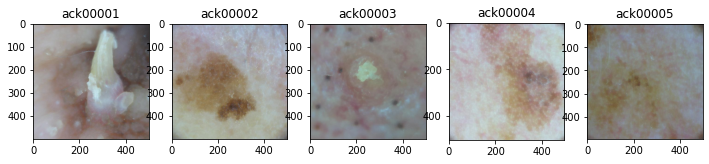

In [46]:
# Show Train Samples
train_samples = train_df_all.head(5)

fig, axes = plt.subplots(nrows=1, ncols = 5, figsize=(12, 5))
ax = 0

for i, row in train_samples.iterrows():
  img_id = row["image_id"]
  img = read_img_prepro(img_id, "train")

  axes[ax].imshow(img)
  axes[ax].set_title(img_id)
  ax +=1 

plt.subplots_adjust()
plt.show()

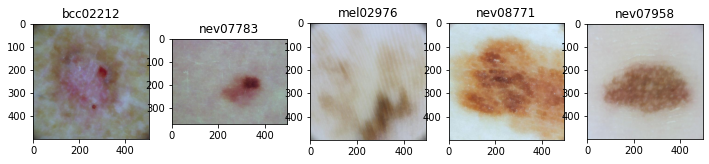

In [47]:
# Show Validation Samples
val_samples = val_df.sample(5)

fig, axes = plt.subplots(nrows=1, ncols = 5, figsize=(12, 5))
ax = 0

for i, row in val_samples.iterrows():
  img_id = row["image_id"]
  img = read_img_prepro(img_id, "val")

  axes[ax].imshow(img)
  axes[ax].set_title(img_id)
  ax +=1 

plt.subplots_adjust()
plt.show()

Feature Extraction and saving

In [ ]:
# Training set (full)
variegation_fd, color_feature_fd, rgb_fd, hsv_fd, lab_fd, lbp_fd, haralick_fd, glcm_fd = extract_save_features( train_df_all, 
                                                                                                                'train', 
                                                                                                                lbp_params={'P':16, 'R':2})

In [ ]:
# ----  Save the extracted features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge1/'

# --  Save Train Features :
if save_path is not None:      
  os.makedirs(os.path.join(save_path, 'features_train'), exist_ok=True)
  with open(os.path.join(save_path, 'features_train', 'train_variegation_fd' + '.pkl'), 'wb') as f:
          pickle.dump(variegation_fd, f)
  print("train_variegation_fd were saved..\n")

  with open(os.path.join(save_path, 'features_train', 'train_color_feature_fd' + '.pkl'), 'wb') as f:
          pickle.dump(color_feature_fd, f)
  print("train_color_feature_fd were saved..\n")

  with open(os.path.join(save_path, 'features_train', 'train_rgb_fd' + '.pkl'), 'wb') as f:
          pickle.dump(rgb_fd, f)
  print("train_rgb_fd were saved..\n")

  with open(os.path.join(save_path, 'features_train', 'train_hsv_fd' + '.pkl'), 'wb') as f:
          pickle.dump(hsv_fd, f)
  print("train_hsv_fd were saved..\n")

  with open(os.path.join(save_path, 'features_train', 'train_lab_fd' + '.pkl'), 'wb') as f:
          pickle.dump(lab_fd, f)
  print("train_lab_ft_fd were saved..\n")

  with open(os.path.join(save_path, 'features_train', 'train_lbp_fd' + '.pkl'), 'wb') as f:
          pickle.dump(lbp_fd, f)
  print("lbp_fd were saved..\n")

  with open(os.path.join(save_path, 'features_train', 'train_haralick_fd' + '.pkl'), 'wb') as f:
          pickle.dump(haralick_fd, f)
  print("haralick_fd were saved..\n")

  with open(os.path.join(save_path, 'features_train', 'train_glcm_fd' + '.pkl'), 'wb') as f:
          pickle.dump(glcm_fd, f)
  print("glcm_fd were saved..\n")

train_variegation_fd were saved..

train_color_feature_fd were saved..

train_rgb_fd were saved..

train_hsv_fd were saved..

train_lab_ft_fd were saved..

lbp_fd were saved..

haralick_fd were saved..

glcm_fd were saved..



In [ ]:
# Validation set
val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd = extract_save_features(val_df, 
                                                                                                                                                        'val', 
                                                                                                                                                        500, 
                                                                                                                                                        crop_params={'threshold':100}, 
                                                                                                                                                        cc_params={'power':6, 'gamma':None}, 
                                                                                                                                                        remove_hair_params={'se_size': 9}, 
                                                                                                                                                        lbp_params={'P':16, 'R':2})

In [ ]:
# Saving the features for future use
save_path = 'data\\'

# --  Save Train Features :
if save_path is not None:      
  os.makedirs(os.path.join(save_path, 'features_val'), exist_ok=True)
  with open(os.path.join(save_path, 'features_val', 'val_variegation_fd' + '.pkl'), 'wb') as f:
          pickle.dump(val_variegation_fd, f)
  print("val_variegation_fd were saved..\n")

  with open(os.path.join(save_path, 'features_val', 'val_color_feature_fd' + '.pkl'), 'wb') as f:
          pickle.dump(val_color_feature_fd, f)
  print("val_color_feature_fd were saved..\n")

  with open(os.path.join(save_path, 'features_val', 'val_rgb_fd' + '.pkl'), 'wb') as f:
          pickle.dump(val_rgb_fd, f)
  print("val_rgb_ft_fd were saved..\n")

  with open(os.path.join(save_path, 'features_val', 'val_hsv_fd' + '.pkl'), 'wb') as f:
          pickle.dump(val_hsv_fd, f)
  print("val_hsv_ft_fd were saved..\n")

  with open(os.path.join(save_path, 'features_val', 'val_lab_fd' + '.pkl'), 'wb') as f:
          pickle.dump(val_lab_fd, f)
  print("val_lab_ft_fd were saved..\n")

  with open(os.path.join(save_path, 'features_val', 'val_lbp_fd' + '.pkl'), 'wb') as f:
          pickle.dump(val_lbp_fd, f)
  print("val_lbp_fd were saved..\n")

  with open(os.path.join(save_path, 'features_val', 'val_haralick_fd' + '.pkl'), 'wb') as f:
          pickle.dump(val_haralick_fd, f)
  print("val_haralick_fd were saved..\n")

  with open(os.path.join(save_path, 'features_val', 'val_glcm_fd' + '.pkl'), 'wb') as f:
          pickle.dump(val_glcm_fd, f)
  print("val_glcm_fd were saved..\n")

val_variegation_fd were saved..

val_color_feature_fd were saved..

val_rgb_ft_fd were saved..

val_hsv_ft_fd were saved..

val_lab_ft_fd were saved..

val_col_asym_fd were saved..

val_lbp_fd were saved..

val_haralick_fd were saved..

val_glcm_fd were saved..



## Train

In this section we will perform Four tasks: 
  - Parameter fine-tuning of each model 
  - Feature selection and dimentionality reduction 
  - Training each model 
  - Validation and Comparison of the results 

For feature selection and dimensionality reduction multiple techniques will be tried: 
* Ablation study on the different extracted features: first we train the model 
with all features at one, then we remove one of the set of extracted features individually to study the contribution of that set of features in the baseline model. After that we retrain the model with the features which the removal harms the results compared to the baseline. The following sets were tried: 
  *   A : All features
  *   B : All - color moments 
  *   C : All - RGB histograms 
  *   D : All - LAB histograms 
  *   E : All - HSV histograms 
  *   F : All - Texture features
  *   G : All - Variegation 
  *   H : The best features based on the previous results 
* Sci-kit Learn feature selection and dimensionality reduction techniques: 
  * Select k best 
  * PCA 
  * Select from model 
* Visual inspection of the features 
  * Without normalization 
  * With normalization



#### Prepare data

In [ ]:
train_csv_all = "/content/drive/MyDrive/CAD_Dataset/Challenge1/train.csv"
train_csv_sm = "/content/drive/MyDrive/CAD_Dataset/Challenge1/train_4000.csv"
val_csv = "/content/drive/MyDrive/CAD_Dataset/Challenge1/val.csv"

In [ ]:
# Read data information as dataframe (image_ids - labels)
train_df = pd.read_csv(train_csv_all)
train_df_sm = pd.read_csv(train_csv_sm)
val_df = pd.read_csv(val_csv)

print(f'Train=>\t\t Total: {len(train_df)}\t Nevus: {len(train_df[train_df["label"]==0])}\t Other: {len(train_df[train_df["label"]==1])}')
print(f'Train - SM=>\t Total: {len(train_df_sm)}\t Nevus: {len(train_df_sm[train_df_sm["label"]==0])}\t Other: {len(train_df_sm[train_df_sm["label"]==1])}')
print(f'Validation=>\t Total: {len(val_df)}\t Nevus: {len(val_df[val_df["label"]==0])}\t Other: {len(val_df[val_df["label"]==1])}')

Train=>		 Total: 15195	 Nevus: 7725	 Other: 7470
Train - SM=>	 Total: 4000	 Nevus: 2000	 Other: 2000
Validation=>	 Total: 3796	 Nevus: 1931	 Other: 1865


##### Train - All sampls

In [48]:
# Open train features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge1/'

# ---  Read Saved Train Features :  ---------------------------------
with open(os.path.join(save_path, 'features_train', 'train_variegation_fd' + '.pkl'), 'rb') as file:
    train_variegation_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_color_feature_fd' + '.pkl'), 'rb') as file:
    train_color_feature_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_rgb_fd' + '.pkl'), 'rb') as file:
    train_rgb_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_hsv_fd' + '.pkl'), 'rb') as file:
    train_hsv_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_lab_fd' + '.pkl'), 'rb') as file:
    train_lab_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_lbp_fd' + '.pkl'), 'rb') as file:
    train_lbp_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_haralick_fd' + '.pkl'), 'rb') as file:
    train_haralick_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_glcm_fd' + '.pkl'), 'rb') as file:
    train_glcm_fd = pickle.load(file)    

In [49]:
print(train_variegation_fd.shape)
print(train_color_feature_fd.shape)
print(train_rgb_fd.shape)
print(train_hsv_fd.shape)
print(train_lab_fd.shape)
print(train_lbp_fd.shape)
print(train_haralick_fd.shape)
print(train_glcm_fd.shape)

(15195, 3)
(15195, 12)
(15195, 192)
(15195, 192)
(15195, 192)
(15195, 18)
(15195, 13)
(15195, 20)


In [50]:
# Storing train labels in an ndarray for training
train_labels = np.array(train_df['label']).squeeze()
print(train_labels.shape)

(15195,)


##### Train - subset

In [ ]:
# Open train features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge1/'

# ---  Read Saved Train+Validation Features :  ---------------------------------
with open(os.path.join(save_path, 'features_train_small', 'variegation_fd_sm' + '.pkl'), 'rb') as file:
    train_variegation_fd_sm = pickle.load(file)

with open(os.path.join(save_path, 'features_train_small', 'color_feature_fd_sm' + '.pkl'), 'rb') as file:
    train_color_feature_fd_sm = pickle.load(file)

with open(os.path.join(save_path, 'features_train_small', 'rgb_fd_sm' + '.pkl'), 'rb') as file:
    train_rgb_fd_sm = pickle.load(file)

with open(os.path.join(save_path, 'features_train_small', 'hsv_fd_sm' + '.pkl'), 'rb') as file:
    train_hsv_fd_sm = pickle.load(file)

with open(os.path.join(save_path, 'features_train_small', 'lab_fd_sm' + '.pkl'), 'rb') as file:
    train_lab_fd_sm = pickle.load(file)

with open(os.path.join(save_path, 'features_train_small', 'lbp_fd_sm' + '.pkl'), 'rb') as file:
    train_lbp_fd_sm = pickle.load(file)

with open(os.path.join(save_path, 'features_train_small', 'haralick_fd_sm' + '.pkl'), 'rb') as file:
    train_haralick_fd_sm = pickle.load(file)

with open(os.path.join(save_path, 'features_train_small', 'glcm_fd_sm' + '.pkl'), 'rb') as file:
    train_glcm_fd_sm = pickle.load(file)  

In [ ]:
print(train_variegation_fd_sm.shape)
print(train_color_feature_fd_sm.shape)
print(train_rgb_fd_sm.shape)
print(train_hsv_fd_sm.shape)
print(train_lab_fd_sm.shape)
print(train_lbp_fd_sm.shape)
print(train_haralick_fd_sm.shape)
print(train_glcm_fd_sm.shape)

(4000, 3)
(4000, 12)
(4000, 192)
(4000, 192)
(4000, 192)
(4000, 18)
(4000, 13)
(4000, 20)


In [ ]:
train_labels_sm = np.array(train_df_sm['label']).squeeze()

In [ ]:
print(train_labels_sm.shape)

(4000,)


##### Validation

In [ ]:
# Open validation features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge1/'

# ---  Read Saved Train+Validation Features :  ---------------------------------
with open(os.path.join(save_path, 'features_val', 'val_variegation_fd' + '.pkl'), 'rb') as file:
    val_variegation_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_color_feature_fd' + '.pkl'), 'rb') as file:
    val_color_feature_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_rgb_fd' + '.pkl'), 'rb') as file:
    val_rgb_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_hsv_fd' + '.pkl'), 'rb') as file:
    val_hsv_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_lab_fd' + '.pkl'), 'rb') as file:
    val_lab_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_lbp_fd' + '.pkl'), 'rb') as file:
    val_lbp_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_haralick_fd' + '.pkl'), 'rb') as file:
    val_haralick_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_glcm_fd' + '.pkl'), 'rb') as file:
    val_glcm_fd = pickle.load(file)    

In [ ]:
print(val_variegation_fd.shape)
print(val_color_feature_fd.shape)
print(val_rgb_fd.shape)
print(val_hsv_fd.shape)
print(val_lab_fd.shape)
print(val_lbp_fd.shape)
print(val_haralick_fd.shape)
print(val_glcm_fd.shape)

(3796, 3)
(3796, 12)
(3796, 192)
(3796, 192)
(3796, 192)
(3796, 18)
(3796, 13)
(3796, 20)


In [ ]:
val_labels = np.array(val_df['label']).squeeze()

In [ ]:
print(val_labels.shape)

(3796,)


#### Data Vizualisation

In this section we visually inspect the extracted features.

##### Variegation

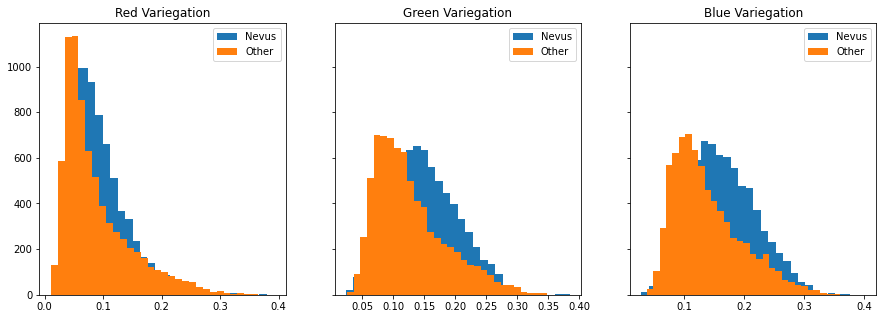

In [ ]:
### Variegation #######################################################################
variegation_nevus_red = train_variegation_fd[train_labels==0, 0]
variegation_nevus_green = train_variegation_fd[train_labels==0, 1]
variegation_nevus_blue = train_variegation_fd[train_labels==0, 2]

variegation_other_red = train_variegation_fd[train_labels==1, 0]
variegation_other_green = train_variegation_fd[train_labels==1, 1]
variegation_other_blue = train_variegation_fd[train_labels==1, 2]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Red
bins = 30
axs[0].hist(variegation_nevus_red, bins, histtype='stepfilled' , label = "Nevus")
axs[0].hist(variegation_other_red, bins, histtype='stepfilled' , label = "Other")
axs[0].legend()
axs[0].set_title("Red Variegation")

# Green
axs[1].hist(variegation_nevus_green, bins, histtype='stepfilled' , label = "Nevus")
axs[1].hist(variegation_other_green, bins, histtype='stepfilled' , label = "Other")
axs[1].legend()
axs[1].set_title("Green Variegation")

# Blue
axs[2].hist(variegation_nevus_blue, bins, histtype='stepfilled' , label = "Nevus")
axs[2].hist(variegation_other_blue, bins, histtype='stepfilled' , label = "Other")
axs[2].legend()
axs[2].set_title("Blue Variegation")

plt.subplots_adjust()
plt.show()

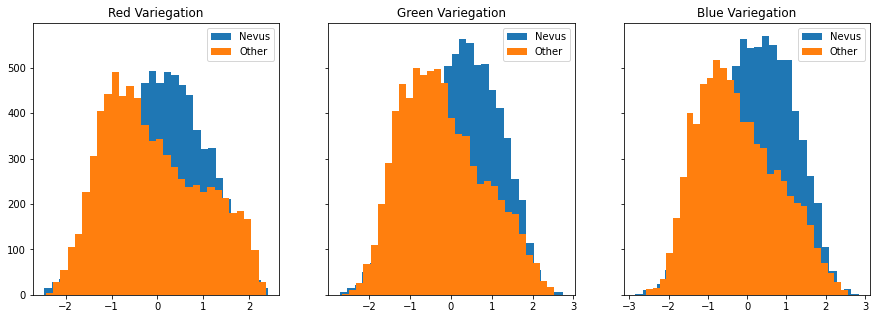

In [ ]:
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_variegation_fd_pp = transform.fit_transform(train_variegation_fd)
variegation_nevus_red = train_variegation_fd_pp[train_labels==0, 0]
variegation_nevus_green = train_variegation_fd_pp[train_labels==0, 1]
variegation_nevus_blue = train_variegation_fd_pp[train_labels==0, 2]

variegation_other_red = train_variegation_fd_pp[train_labels==1, 0]
variegation_other_green = train_variegation_fd_pp[train_labels==1, 1]
variegation_other_blue = train_variegation_fd_pp[train_labels==1, 2]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Red
bins = 30
axs[0].hist(variegation_nevus_red, bins, histtype='stepfilled' , label = "Nevus")
axs[0].hist(variegation_other_red, bins, histtype='stepfilled' , label = "Other")
axs[0].legend()
axs[0].set_title("Red Variegation")

# Green
axs[1].hist(variegation_nevus_green, bins, histtype='stepfilled' , label = "Nevus")
axs[1].hist(variegation_other_green, bins, histtype='stepfilled' , label = "Other")
axs[1].legend()
axs[1].set_title("Green Variegation")

# Blue
axs[2].hist(variegation_nevus_blue, bins, histtype='stepfilled' , label = "Nevus")
axs[2].hist(variegation_other_blue, bins, histtype='stepfilled' , label = "Other")
axs[2].legend()
axs[2].set_title("Blue Variegation")

plt.subplots_adjust()
plt.show()

##### RGB Histograms

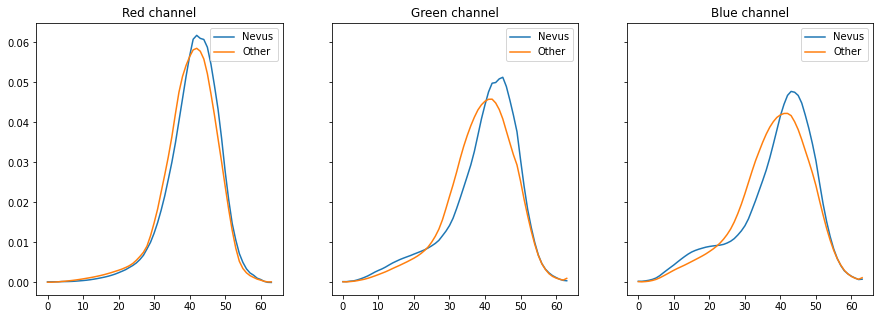

In [ ]:
### Color histograms => RGB #######################################################################
rgb_nevus_red = np.mean(train_rgb_fd[train_labels==0, 0:64], axis = 0)
rgb_nevus_green = np.mean(train_rgb_fd[train_labels==0, 64:128], axis = 0)
rgb_nevus_blue = np.mean(train_rgb_fd[train_labels==0, 128:], axis = 0)

rgb_other_red = np.mean(train_rgb_fd[train_labels==1, 0:64], axis = 0)
rgb_other_green = np.mean(train_rgb_fd[train_labels==1, 64:128], axis = 0)
rgb_other_blue = np.mean(train_rgb_fd[train_labels==1, 128:], axis = 0)


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, rgb_nevus_red, label='Nevus')
axs[0].plot(x, rgb_other_red, label='Other')
axs[0].legend()
axs[0].set_title("Red channel")

# Green
axs[1].plot(x, rgb_nevus_green, label='Nevus')
axs[1].plot(x, rgb_other_green, label='Other')
axs[1].legend()
axs[1].set_title("Green channel")

# Blue
axs[2].plot(x, rgb_nevus_blue, label='Nevus')
axs[2].plot(x, rgb_other_blue, label='Other')
axs[2].legend()
axs[2].set_title("Blue channel")

plt.subplots_adjust()
plt.show()

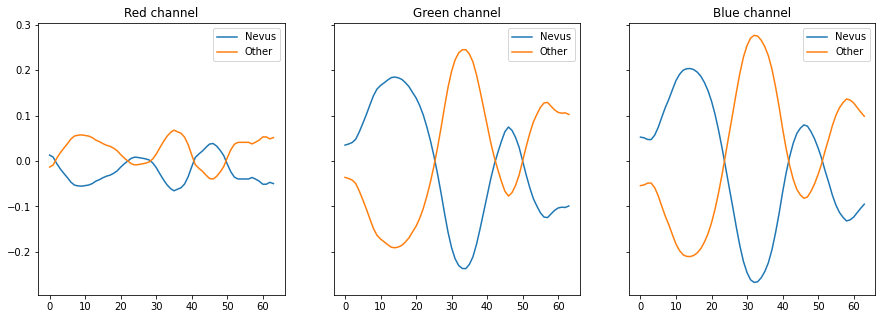

In [ ]:
### Color histograms => RGB #######################################################################
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_rgb_fd_pp = transform.fit_transform(train_rgb_fd)

rgb_nevus_red = np.mean(train_rgb_fd_pp[train_labels==0, 0:64], axis = 0)
rgb_nevus_green = np.mean(train_rgb_fd_pp[train_labels==0, 64:128], axis = 0)
rgb_nevus_blue = np.mean(train_rgb_fd_pp[train_labels==0, 128:], axis = 0)

rgb_other_red = np.mean(train_rgb_fd_pp[train_labels==1, 0:64], axis = 0)
rgb_other_green = np.mean(train_rgb_fd_pp[train_labels==1, 64:128], axis = 0)
rgb_other_blue = np.mean(train_rgb_fd_pp[train_labels==1, 128:], axis = 0)


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, rgb_nevus_red, label='Nevus')
axs[0].plot(x, rgb_other_red, label='Other')
axs[0].legend()
axs[0].set_title("Red channel")

# Green
axs[1].plot(x, rgb_nevus_green, label='Nevus')
axs[1].plot(x, rgb_other_green, label='Other')
axs[1].legend()
axs[1].set_title("Green channel")

# Blue
axs[2].plot(x, rgb_nevus_blue, label='Nevus')
axs[2].plot(x, rgb_other_blue, label='Other')
axs[2].legend()
axs[2].set_title("Blue channel")

plt.subplots_adjust()
plt.show()

##### HSV Histograms

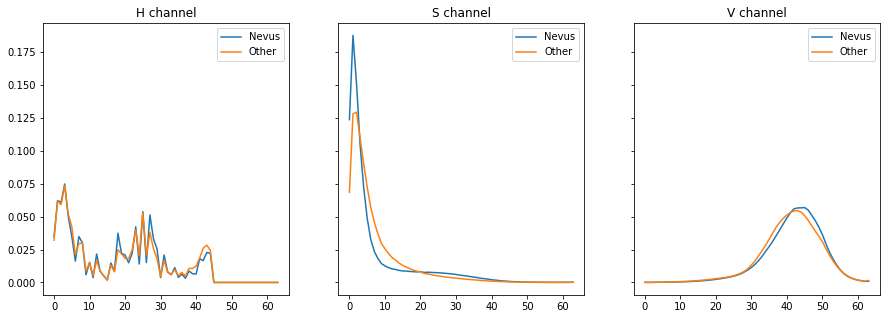

In [ ]:
### Color histograms => HSV #######################################################################
hsv_nevus_h = np.mean(train_hsv_fd[train_labels==0, 0:64], axis = 0)
hsv_nevus_s = np.mean(train_hsv_fd[train_labels==0, 64:128], axis = 0)
hsv_nevus_v = np.mean(train_hsv_fd[train_labels==0, 128:], axis = 0)

hsv_other_h = np.mean(train_hsv_fd[train_labels==1, 0:64], axis = 0)
hsv_other_s = np.mean(train_hsv_fd[train_labels==1, 64:128], axis = 0)
hsv_other_v = np.mean(train_hsv_fd[train_labels==1, 128:], axis = 0)


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, hsv_nevus_h, label='Nevus')
axs[0].plot(x, hsv_other_h, label='Other')
axs[0].legend()
axs[0].set_title("H channel")

# Green
axs[1].plot(x, hsv_nevus_s, label='Nevus')
axs[1].plot(x, hsv_other_s, label='Other')
axs[1].legend()
axs[1].set_title("S channel")

# Blue
axs[2].plot(x, hsv_nevus_v, label='Nevus')
axs[2].plot(x, hsv_other_v, label='Other')
axs[2].legend()
axs[2].set_title("V channel")

plt.subplots_adjust()
plt.show()

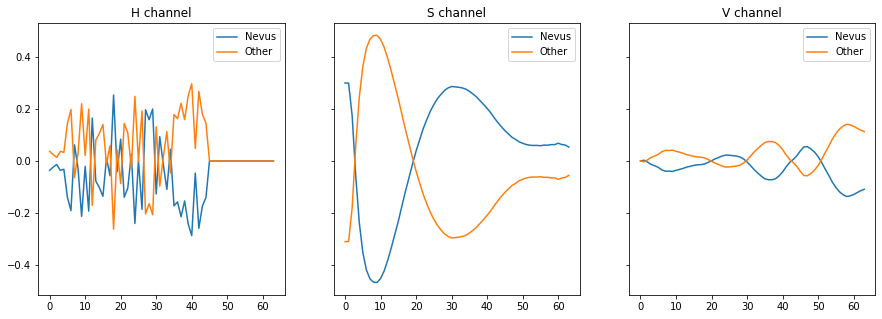

In [ ]:
### Color histograms => HSV #######################################################################
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_hsv_fd_pp = transform.fit_transform(train_hsv_fd)

hsv_nevus_h = np.mean(train_hsv_fd_pp[train_labels==0, 0:64], axis = 0)
hsv_nevus_s = np.mean(train_hsv_fd_pp[train_labels==0, 64:128], axis = 0)
hsv_nevus_v = np.mean(train_hsv_fd_pp[train_labels==0, 128:], axis = 0)

hsv_other_h = np.mean(train_hsv_fd_pp[train_labels==1, 0:64], axis = 0)
hsv_other_s = np.mean(train_hsv_fd_pp[train_labels==1, 64:128], axis = 0)
hsv_other_v = np.mean(train_hsv_fd_pp[train_labels==1, 128:], axis = 0)


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, hsv_nevus_h, label='Nevus')
axs[0].plot(x, hsv_other_h, label='Other')
axs[0].legend()
axs[0].set_title("H channel")

# Green
axs[1].plot(x, hsv_nevus_s, label='Nevus')
axs[1].plot(x, hsv_other_s, label='Other')
axs[1].legend()
axs[1].set_title("S channel")

# Blue
axs[2].plot(x, hsv_nevus_v, label='Nevus')
axs[2].plot(x, hsv_other_v, label='Other')
axs[2].legend()
axs[2].set_title("V channel")

plt.subplots_adjust()
plt.show()

##### LAB Histograms

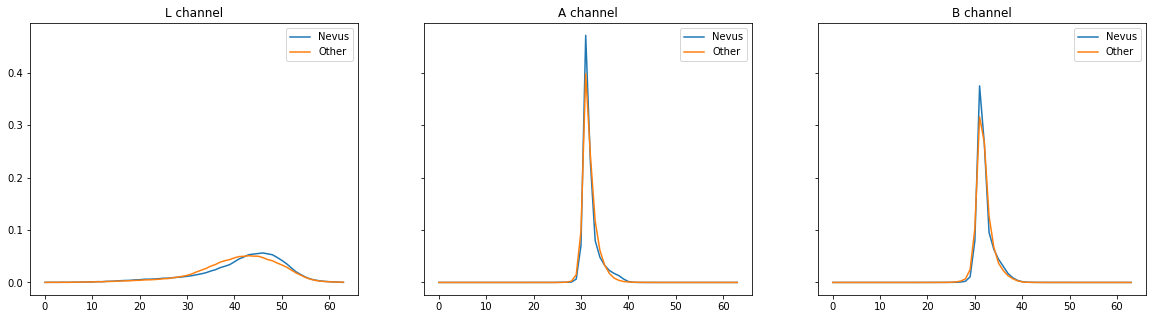

In [ ]:
### Color histograms => LAB #######################################################################
lab_nevus_l = np.mean(train_lab_fd[train_labels==0, 0:64], axis = 0)
lab_nevus_a = np.mean(train_lab_fd[train_labels==0, 64:128], axis = 0)
lab_nevus_b = np.mean(train_lab_fd[train_labels==0, 128:], axis = 0)

lab_other_l = np.mean(train_lab_fd[train_labels==1, 0:64], axis = 0)
lab_other_a = np.mean(train_lab_fd[train_labels==1, 64:128], axis = 0)
lab_other_b = np.mean(train_lab_fd[train_labels==1, 128:], axis = 0)


fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, lab_nevus_l, label='Nevus')
axs[0].plot(x, lab_other_l, label='Other')
axs[0].legend()
axs[0].set_title("L channel")

# Green
axs[1].plot(x, lab_nevus_a, label='Nevus')
axs[1].plot(x, lab_other_a, label='Other')
axs[1].legend()
axs[1].set_title("A channel")

# Blue
axs[2].plot(x, lab_nevus_b, label='Nevus')
axs[2].plot(x, lab_other_b, label='Other')
axs[2].legend()
axs[2].set_title("B channel")

plt.subplots_adjust()
plt.show()

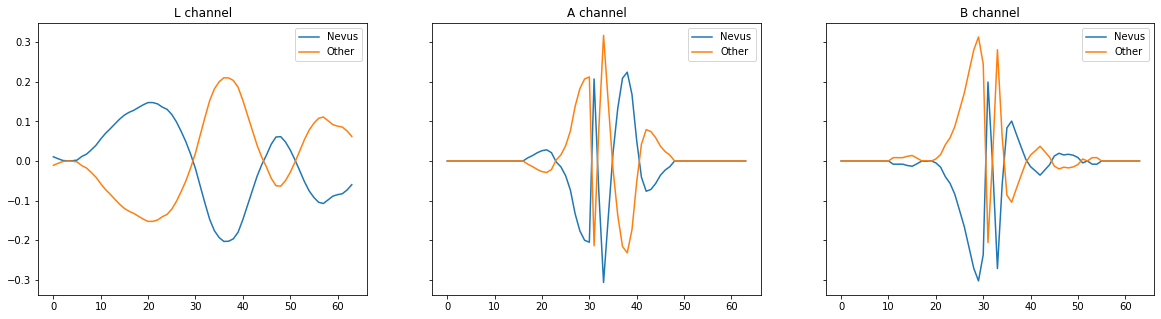

In [ ]:
### Color histograms => LAB #######################################################################
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_lab_fd_pp = transform.fit_transform(train_lab_fd)

lab_nevus_l = np.mean(train_lab_fd_pp[train_labels==0, 0:64], axis = 0)
lab_nevus_a = np.mean(train_lab_fd_pp[train_labels==0, 64:128], axis = 0)
lab_nevus_b = np.mean(train_lab_fd_pp[train_labels==0, 128:], axis = 0)

lab_other_l = np.mean(train_lab_fd_pp[train_labels==1, 0:64], axis = 0)
lab_other_a = np.mean(train_lab_fd_pp[train_labels==1, 64:128], axis = 0)
lab_other_b = np.mean(train_lab_fd_pp[train_labels==1, 128:], axis = 0)


fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, lab_nevus_l, label='Nevus')
axs[0].plot(x, lab_other_l, label='Other')
axs[0].legend()
axs[0].set_title("L channel")

# Green
axs[1].plot(x, lab_nevus_a, label='Nevus')
axs[1].plot(x, lab_other_a, label='Other')
axs[1].legend()
axs[1].set_title("A channel")

# Blue
axs[2].plot(x, lab_nevus_b, label='Nevus')
axs[2].plot(x, lab_other_b, label='Other')
axs[2].legend()
axs[2].set_title("B channel")

plt.subplots_adjust()
plt.show()

##### Color Moments

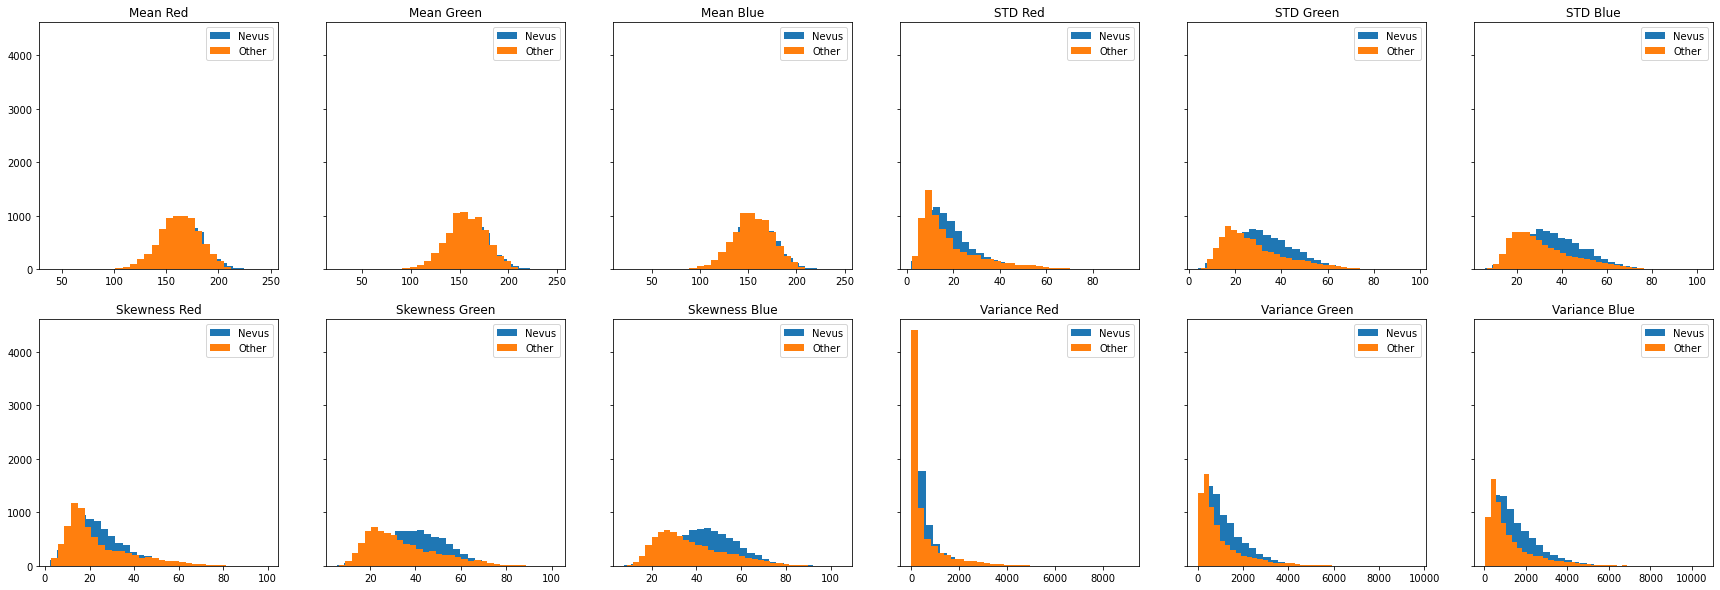

In [ ]:
### COLOR MOMENTS 
titles = ["Mean Red", "Mean Green", "Mean Blue", "STD Red", "STD Green", "STD Blue", "Skewness Red", "Skewness Green", "Skewness Blue", "Variance Red", "Variance Green", "Variance Blue"]
fig, axs = plt.subplots(2, 6, figsize=(30, 10), sharey=True)
bins = 30
for i in range(0, 12):
  row = int(i/6)
  col = i % 6
  nevus_feature = train_color_feature_fd[train_labels==0, i]
  other_feature = train_color_feature_fd[train_labels==1, i]
  axs[row, col].hist(nevus_feature, bins, histtype='stepfilled' , label = "Nevus")
  axs[row, col].hist(other_feature, bins, histtype='stepfilled' , label = "Other")
  axs[row, col].legend()
  axs[row, col].set_title(titles[i])

plt.subplots_adjust()
plt.show()

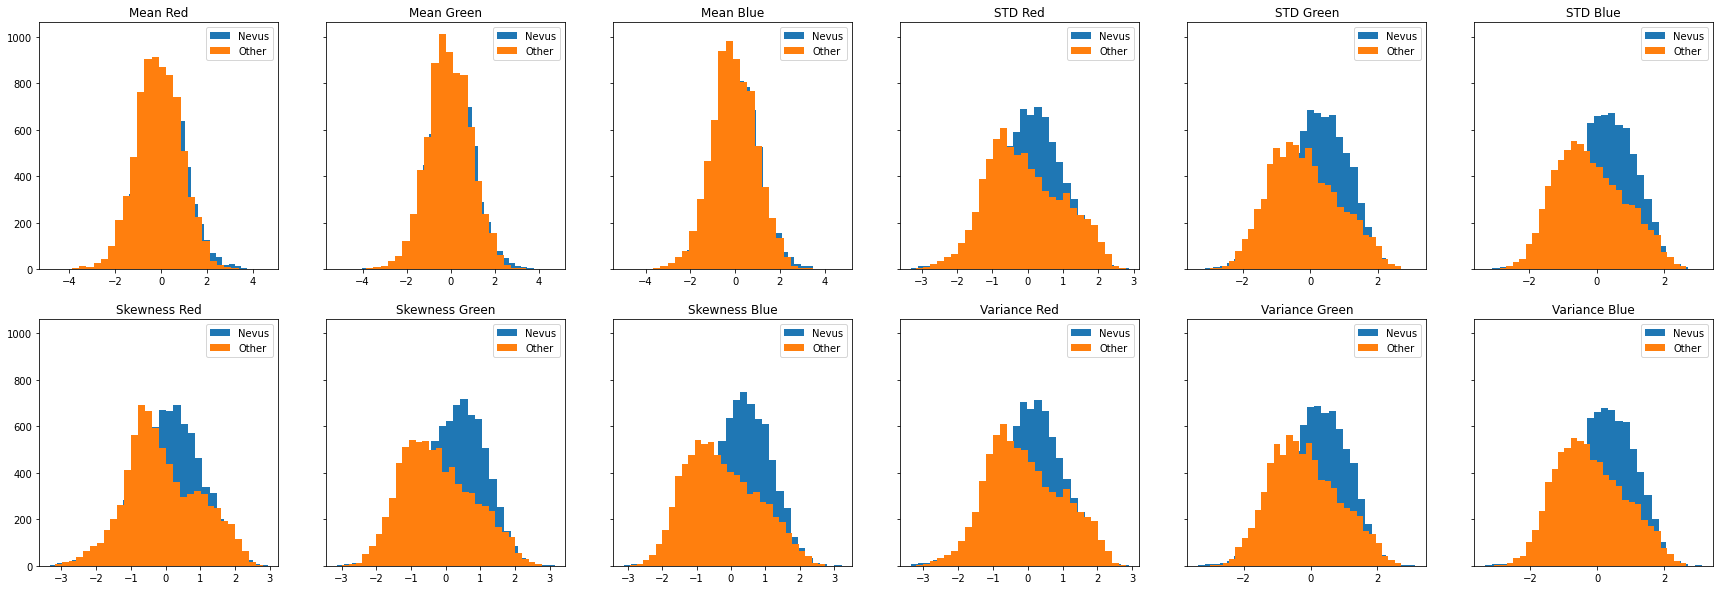

In [ ]:
### COLOR MOMENTS  + PP
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_color_feature_fd_pp = transform.fit_transform(train_color_feature_fd)


titles = ["Mean Red", "Mean Green", "Mean Blue", "STD Red", "STD Green", "STD Blue", "Skewness Red", "Skewness Green", "Skewness Blue", "Variance Red", "Variance Green", "Variance Blue"]
fig, axs = plt.subplots(2, 6, figsize=(30, 10), sharey=True)
bins = 30
for i in range(0, 12):
  row = int(i/6)
  col = i % 6
  nevus_feature = train_color_feature_fd_pp[train_labels==0, i]
  other_feature = train_color_feature_fd_pp[train_labels==1, i]
  axs[row, col].hist(nevus_feature, bins, histtype='stepfilled' , label = "Nevus")
  axs[row, col].hist(other_feature, bins, histtype='stepfilled' , label = "Other")
  axs[row, col].legend()
  axs[row, col].set_title(titles[i])

plt.subplots_adjust()
plt.show()

##### GLCM

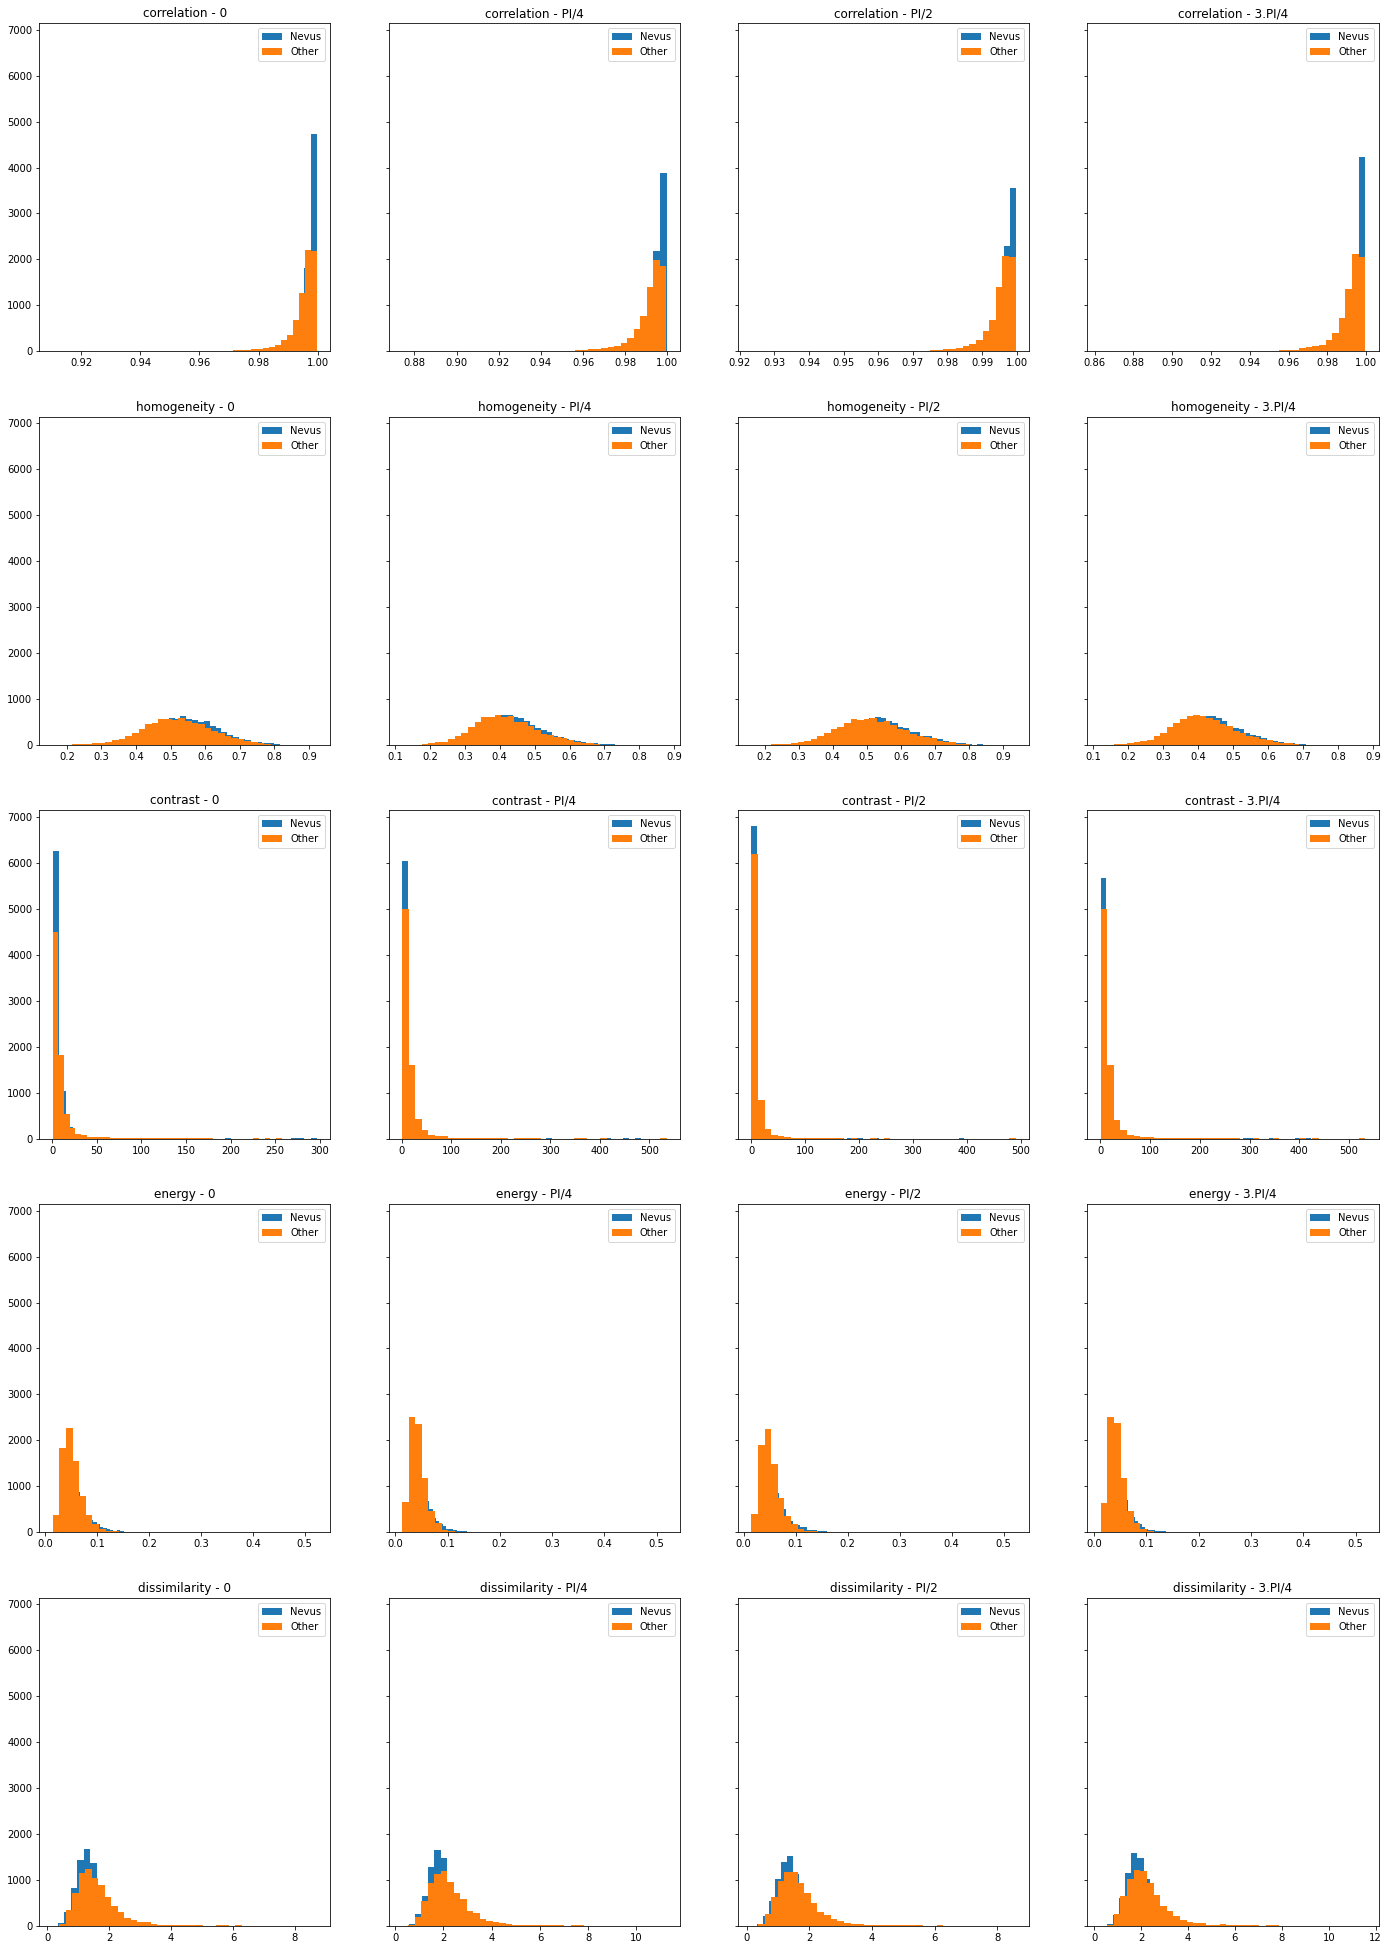

In [51]:
angles = ["0", "PI/4", "PI/2", "3.PI/4"]
properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
fig, axs = plt.subplots(5, 4, figsize=(24, 35), sharey=True)
bins = 40
for i in range(0, 20):
  row = int(i/4)
  col = i % 4
  nevus_feature = train_glcm_fd[train_labels==0, i]
  other_feature = train_glcm_fd[train_labels==1, i]
  axs[row, col].hist(nevus_feature, bins, histtype='stepfilled' , label = "Nevus")
  axs[row, col].hist(other_feature, bins, histtype='stepfilled' , label = "Other")
  axs[row, col].legend()

  axs[row, col].set_title(f"{properties[row]} - {angles[col]}")

plt.subplots_adjust()
plt.show()

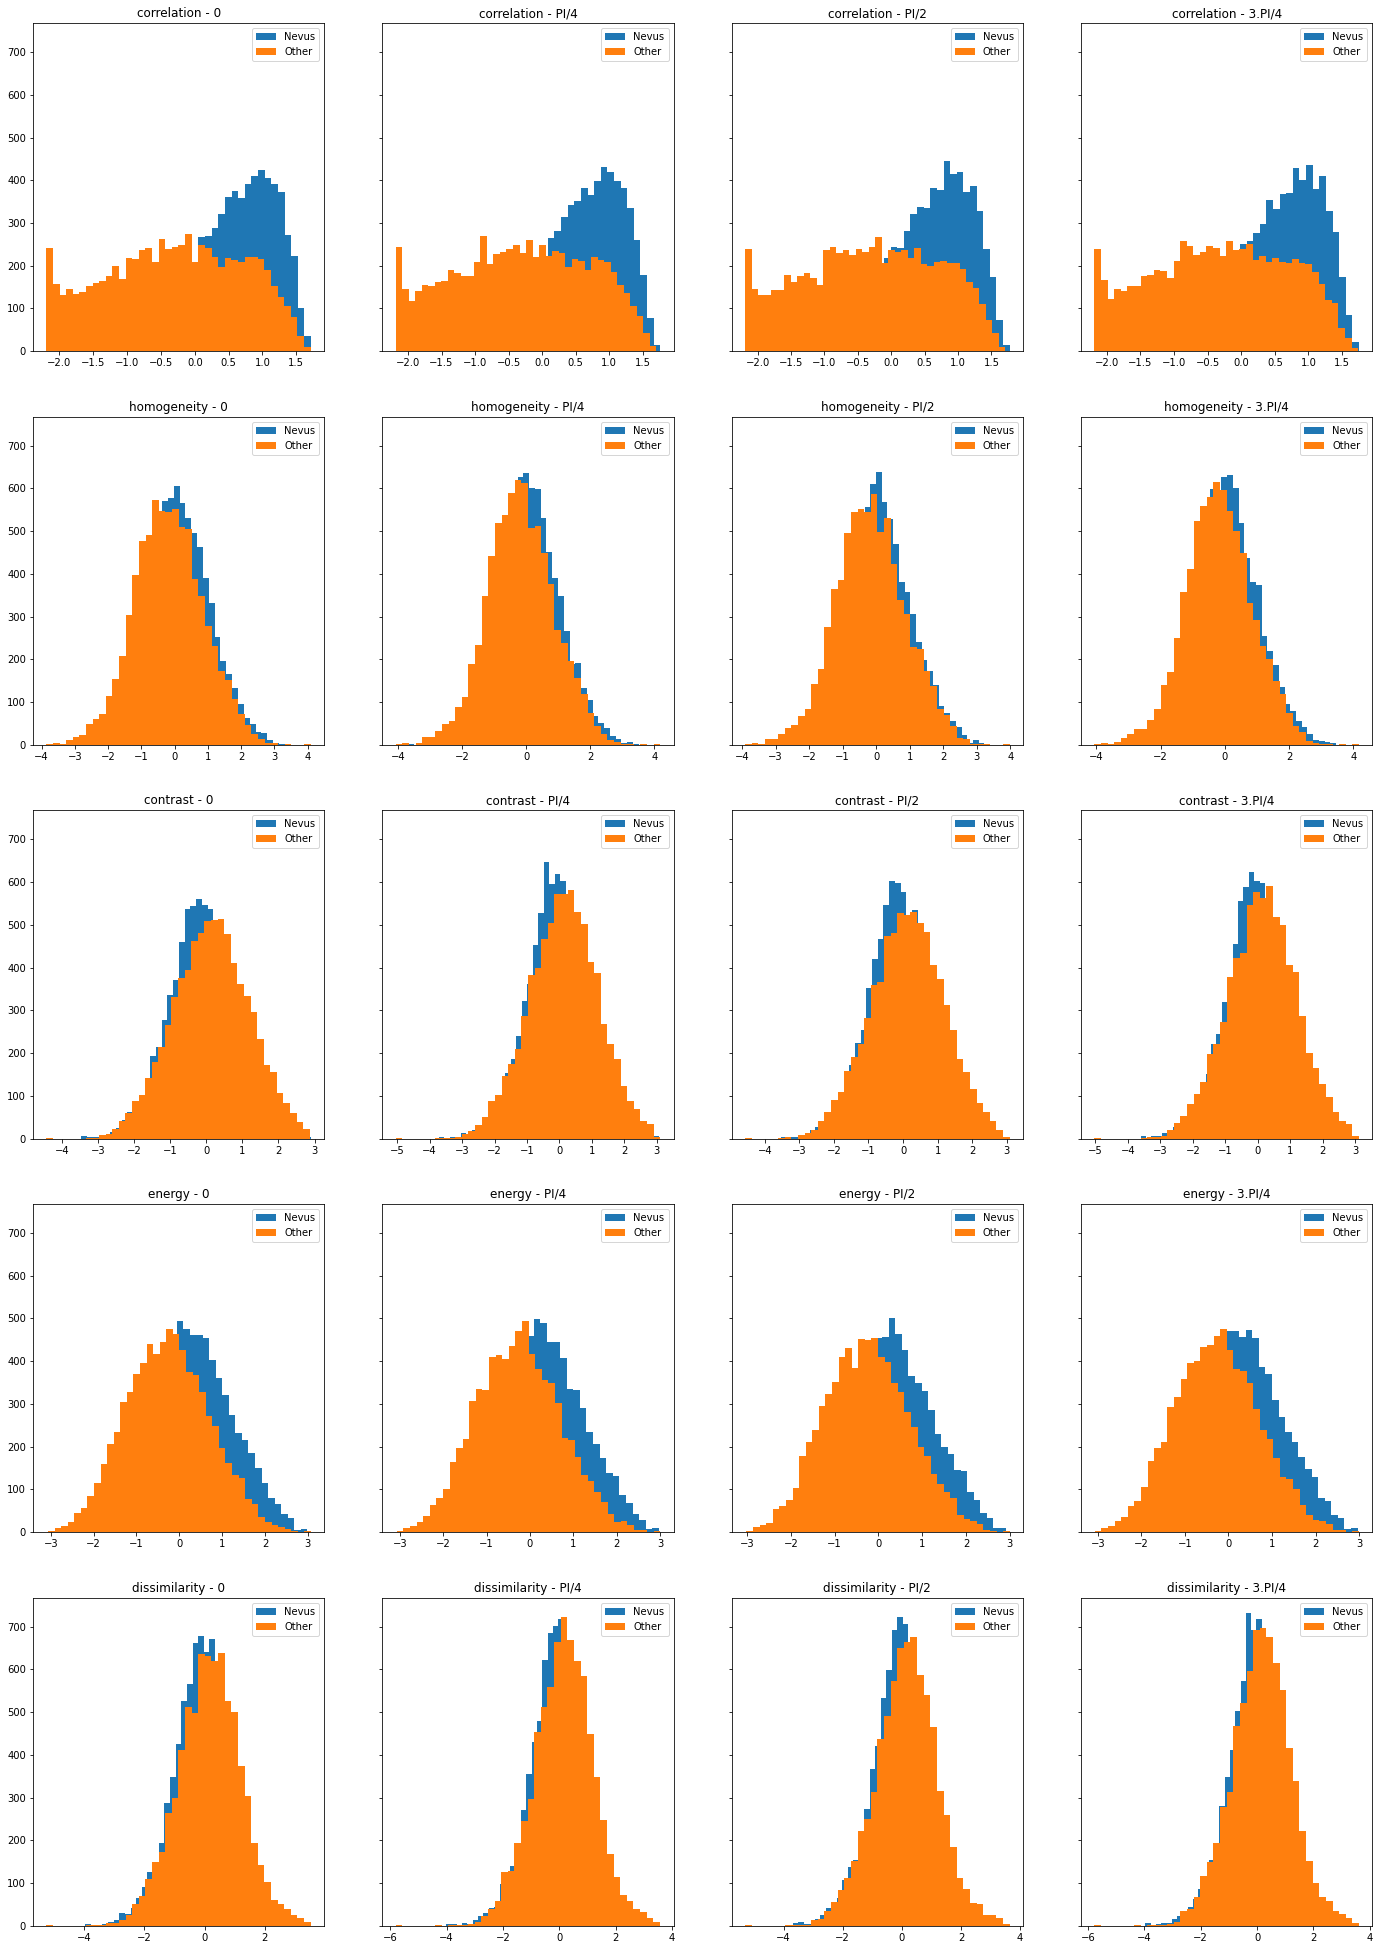

In [ ]:
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_glcm_fd_pp = transform.fit_transform(train_glcm_fd)


angles = ["0", "PI/4", "PI/2", "3.PI/4"]
properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
fig, axs = plt.subplots(5, 4, figsize=(24, 35), sharey=True)
bins = 40
for i in range(0, 20):
  row = int(i/4)
  col = i % 4
  nevus_feature = train_glcm_fd_pp[train_labels==0, i]
  other_feature = train_glcm_fd_pp[train_labels==1, i]
  axs[row, col].hist(nevus_feature, bins, histtype='stepfilled' , label = "Nevus")
  axs[row, col].hist(other_feature, bins, histtype='stepfilled' , label = "Other")
  axs[row, col].legend()

  axs[row, col].set_title(f"{properties[row]} - {angles[col]}")

plt.subplots_adjust()
plt.show()

##### Haralick

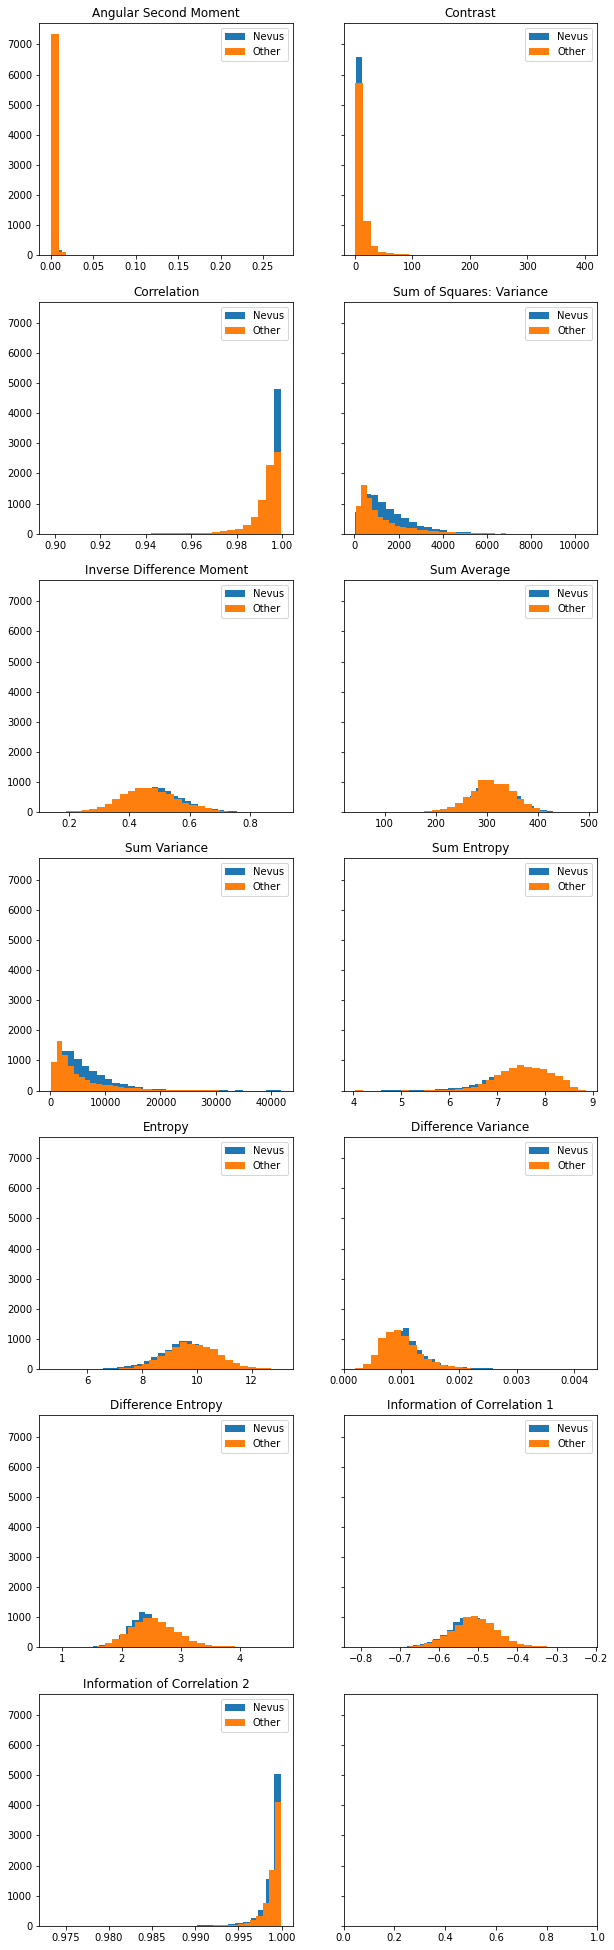

In [ ]:
titles =["Angular Second Moment",
          "Contrast",
          "Correlation",
          "Sum of Squares: Variance",
          "Inverse Difference Moment",
          "Sum Average",
          "Sum Variance",
          "Sum Entropy",
          "Entropy",
          "Difference Variance",
          "Difference Entropy",
          "Information of Correlation 1",
          "Information of Correlation 2"]
fig, axs = plt.subplots(7, 2, figsize=(10, 35), sharey=True)
bins = 30
for i in range(0, 13):
  row = int(i/2)
  col = i % 2
  nevus_feature = train_haralick_fd[train_labels==0, i]
  other_feature = train_haralick_fd[train_labels==1, i]
  axs[row, col].hist(nevus_feature, bins, histtype='stepfilled' , label = "Nevus")
  axs[row, col].hist(other_feature, bins, histtype='stepfilled' , label = "Other")
  axs[row, col].legend()
  axs[row, col].set_title(titles[i])

plt.subplots_adjust()
plt.show()

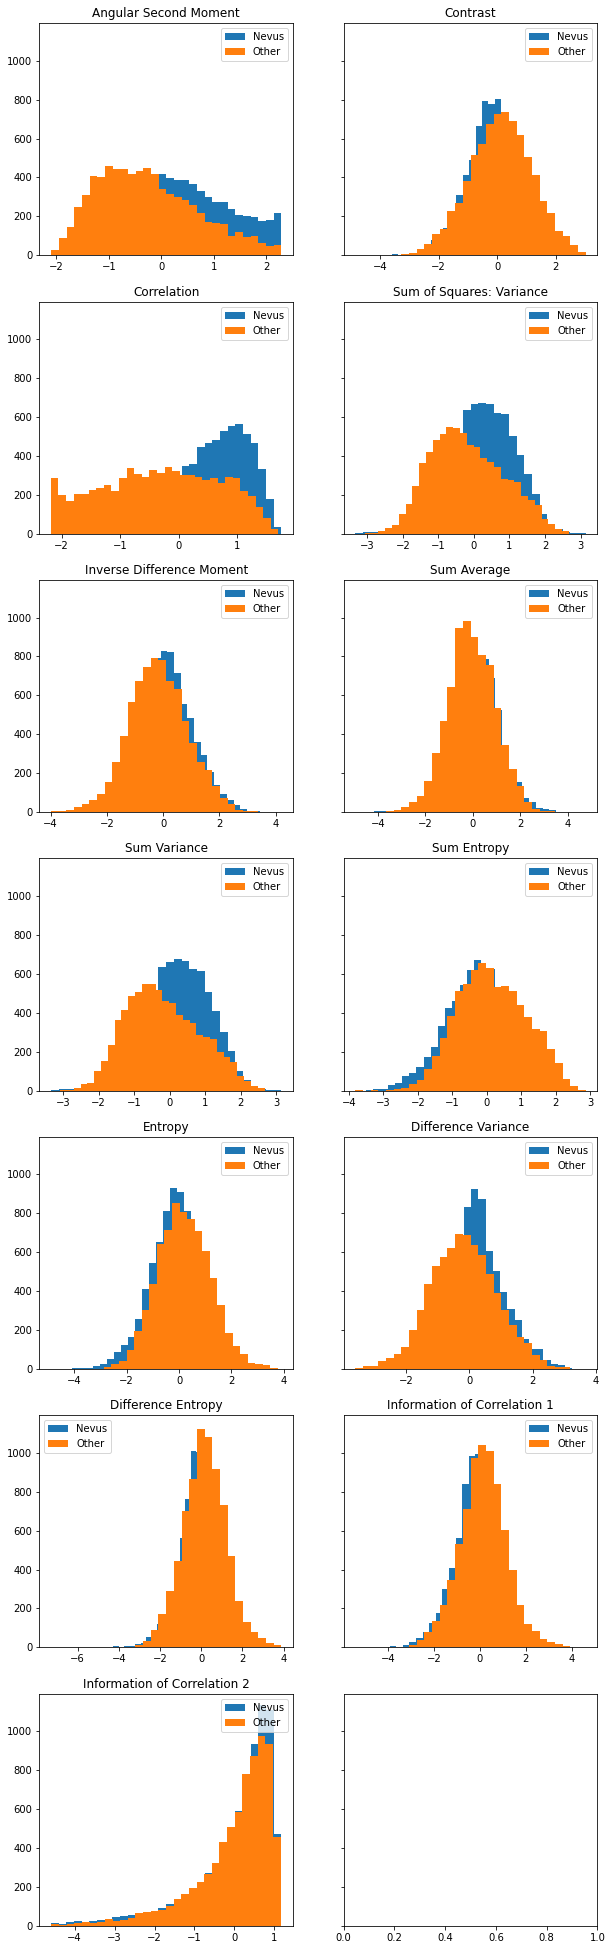

In [ ]:
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_haralick_fd_pp = transform.fit_transform(train_haralick_fd)

titles =["Angular Second Moment",
          "Contrast",
          "Correlation",
          "Sum of Squares: Variance",
          "Inverse Difference Moment",
          "Sum Average",
          "Sum Variance",
          "Sum Entropy",
          "Entropy",
          "Difference Variance",
          "Difference Entropy",
          "Information of Correlation 1",
          "Information of Correlation 2"]
fig, axs = plt.subplots(7, 2, figsize=(10, 35), sharey=True)
bins = 30
for i in range(0, 13):
  row = int(i/2)
  col = i % 2
  nevus_feature = train_haralick_fd_pp[train_labels==0, i]
  other_feature = train_haralick_fd_pp[train_labels==1, i]
  axs[row, col].hist(nevus_feature, bins, histtype='stepfilled' , label = "Nevus")
  axs[row, col].hist(other_feature, bins, histtype='stepfilled' , label = "Other")
  axs[row, col].legend()
  axs[row, col].set_title(titles[i])

plt.subplots_adjust()
plt.show()

##### LBP

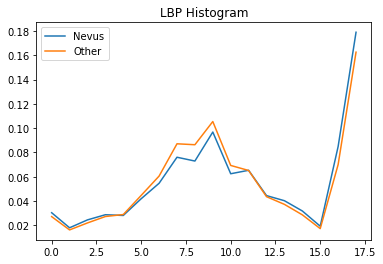

In [ ]:
### Color histograms => RGB #######################################################################
lbp_nevus = np.mean(train_lbp_fd[train_labels==0, :], axis = 0)
lbp_other = np.mean(train_lbp_fd[train_labels==1, :], axis = 0)

plt.plot(lbp_nevus, label='Nevus')
plt.plot(lbp_other, label='Other')
plt.legend()
plt.title("LBP Histogram")

plt.show()

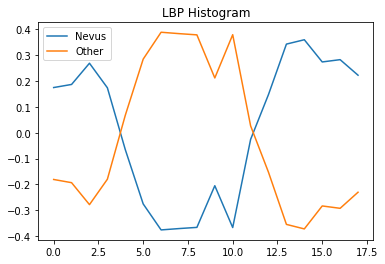

In [ ]:
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_lbp_fd_pp = transform.fit_transform(train_lbp_fd)


lbp_nevus = np.mean(train_lbp_fd_pp[train_labels==0, :], axis = 0)
lbp_other = np.mean(train_lbp_fd_pp[train_labels==1, :], axis = 0)

plt.plot(lbp_nevus, label='Nevus')
plt.plot(lbp_other, label='Other')
plt.legend()
plt.title("LBP Histogram")

plt.show()

#### Baseline: NN + All features

In [ ]:
train_features_sm_all = np.hstack([train_variegation_fd_sm, train_color_feature_fd_sm, train_rgb_fd_sm, train_hsv_fd_sm, train_lab_fd_sm, train_lbp_fd_sm, train_haralick_fd_sm, train_glcm_fd_sm])
train_features_all = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_sm_all.shape)
print(train_features_all.shape)
print(val_features_all.shape)

(4000, 642)
(15195, 642)
(3796, 642)


In [ ]:
# -- Nearest Neighbor :  ------------------------------------------------------------------
# ------------  Using a small training set
strt= time.time()

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()
# define the nearest neighbor classifier
knn = KNeighborsClassifier(n_neighbors = 1)
baseline_pipe_sm = Pipeline(steps=[("scaler", scaler), ("knn", knn)])

baseline_pipe_sm.fit(train_features_sm_all, train_labels_sm)
y_pred_baseline_sm = baseline_pipe_sm.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred_baseline_sm, val_labels) # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores NN classifier - small train :', scores)

Total Time = 1.119297981262207
Scores NN classifier - small train : {'confusion_matrix': array([[1315,  616],
       [ 467, 1398]]), 'accuracy': 0.7146996838777661, 'kappa': 0.4300050579108611}


In [ ]:
# -----------  Using the original training set
strt= time.time()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
knn = KNeighborsClassifier(n_neighbors = 1)
baseline_pipe_all = Pipeline(steps=[("scaler", scaler), ("knn", knn)])

baseline_pipe_all.fit(train_features_all, train_labels)
y_pred_baseline_all = baseline_pipe_all.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred_baseline_all, val_labels) # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores NN classifier - all training data :', scores)

Total Time = 4.242042303085327
Scores NN classifier - all training data : {'confusion_matrix': array([[1430,  501],
       [ 376, 1489]]), 'accuracy': 0.7689673340358272, 'kappa': 0.5383237552143427}


In [ ]:
save_path="/content/drive/MyDrive/CAD_Dataset/Challenge1/"
with open(os.path.join(save_path, 'models', 'nn.pkl'), 'wb') as f:
        pickle.dump(baseline_pipe_all, f)
print("Model saved..\n")

Model saved..



#### k-NN

##### Fine-tuning

Here we estimate the best value of the number of neighbors to be used (k) using GridSearchCV and the small training set

In [ ]:
train_features_sm_all = np.hstack([train_variegation_fd_sm, train_color_feature_fd_sm, train_rgb_fd_sm, train_hsv_fd_sm, train_lab_fd_sm, train_lbp_fd_sm, train_haralick_fd_sm, train_glcm_fd_sm])
train_features_all = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_sm_all.shape)
print(train_features_all.shape)
print(val_features_all.shape)

(4000, 642)
(15195, 642)
(3796, 642)


In [ ]:
# TRAIN SUBSET

# Initialize
strt = time.time()
scaler = StandardScaler() # standard scaler for data normalization
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[("scaler", scaler), ("knn", model)])
params = {'knn__n_neighbors':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_sm_a = grid_search.best_estimator_

# Evaluation
y_pred = knn_sm_a.predict(val_features_all)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Training best_score_ : 0.7387499999999999
Best Parameters {'knn__n_neighbors': 20}
Total Time = 7.555914878845215
Scores KNN classifier : {'confusion_matrix': array([[1392,  539],
       [ 391, 1474]]), 'accuracy': 0.7550052687038988, 'kappa': 0.510526180058283}


##### Features A (model base-line)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors = grid_search.best_params_['knn__n_neighbors'])
scaler = StandardScaler()
knn_lg_a = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
# Training
knn_lg_a.fit(train_features_all, train_labels)
# Evaluation
y_pred = knn_lg_a.predict(val_features_all)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 5.411661624908447
Scores KNN classifier : {'confusion_matrix': array([[1452,  479],
       [ 368, 1497]]), 'accuracy': 0.7768703898840885, 'kappa': 0.5540594145096032}


Confusion matrix, without normalization
[[1452  479]
 [ 368 1497]]


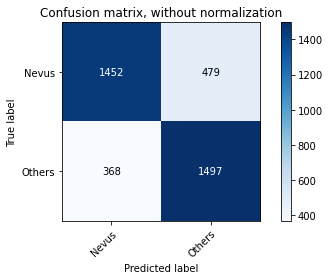

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
# save model to drive 
with open(os.path.join(save_path, 'models', 'knn_a' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_a, f)
print("Model saved..\n")

Model saved..



##### Features B

In [ ]:
train_features_b = np.hstack([train_variegation_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_b = np.hstack([val_variegation_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_b.shape)
print(val_features_b.shape)

(15195, 630)
(3796, 630)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors = 20)
scaler = StandardScaler()
knn_lg_b = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
# Training
knn_lg_b.fit(train_features_b, train_labels)
# Evaluation
y_pred = knn_lg_b.predict(val_features_b)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 6.996317386627197
Scores KNN classifier : {'confusion_matrix': array([[1456,  475],
       [ 371, 1494]]), 'accuracy': 0.7771338250790305, 'kappa': 0.5545573656070731}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_b' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_b, f)
print("Model saved..\n")

Model saved..



##### Features C

In [ ]:
train_features_c = np.hstack([train_variegation_fd, train_color_feature_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_c = np.hstack([val_variegation_fd, val_color_feature_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_c.shape)
print(val_features_c.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors = 20)
scaler = StandardScaler()
knn_lg_c = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
# Training
knn_lg_c.fit(train_features_c, train_labels)
# Evaluation
y_pred = knn_lg_c.predict(val_features_c)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 3.3438446521759033
Scores KNN classifier : {'confusion_matrix': array([[1460,  471],
       [ 377, 1488]]), 'accuracy': 0.7766069546891464, 'kappa': 0.5534634311179867}


In [ ]:
with open(os.path.join(save_path,'models', 'knn_c' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_c, f)
print("Model saved..\n")

Model saved..



##### Features D

In [ ]:
train_features_d = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_d = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_d.shape)
print(val_features_d.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors = 20)
scaler = StandardScaler()
knn_lg_d = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
# Training
knn_lg_d.fit(train_features_d, train_labels)
# Evaluation
y_pred = knn_lg_d.predict(val_features_d)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 2.785932779312134
Scores KNN classifier : {'confusion_matrix': array([[1452,  479],
       [ 377, 1488]]), 'accuracy': 0.7744994731296101, 'kappa': 0.5492838339925226}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_d' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_d, f)
print("Model saved..\n")

Model saved..



##### Features E


In [ ]:
train_features_e = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_e = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_e.shape)
print(val_features_e.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors = 20)
scaler = StandardScaler()
knn_lg_e = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
# preprocessing and model pipeline initialization
knn_lg_e.fit(train_features_e, train_labels)
# Evaluation
y_pred = knn_lg_e.predict(val_features_e)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 2.8029837608337402
Scores KNN classifier : {'confusion_matrix': array([[1480,  451],
       [ 373, 1492]]), 'accuracy': 0.7829293993677555, 'kappa': 0.5660376887301468}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_e' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_e, f)
print("Model saved..\n")

Model saved..



##### Features F

In [ ]:
train_features_f = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd]) 
val_features_f = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd])

In [ ]:
print(train_features_f.shape)
print(val_features_f.shape)

(15195, 591)
(3796, 591)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors = grid_search.best_params_['knn__n_neighbors'])
scaler = StandardScaler()
knn_lg_f = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
# Training
knn_lg_f.fit(train_features_f, train_labels)
# Evaluation
y_pred = knn_lg_f.predict(val_features_f)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 3.787203311920166
Scores KNN classifier : {'confusion_matrix': array([[1399,  532],
       [ 405, 1460]]), 'accuracy': 0.7531612223393045, 'kappa': 0.5067471805621735}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_f' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_f, f)
print("Model saved..\n")

Model saved..



##### Features G

In [ ]:
train_features_g = np.hstack([train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_g = np.hstack([val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_g.shape)
print(val_features_g.shape)

(15195, 639)
(3796, 639)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors = 20)
scaler = StandardScaler()
knn_lg_g = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
# Training
knn_lg_g.fit(train_features_g, train_labels)
# Evaluation
y_pred = knn_lg_g.predict(val_features_g)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 3.5719070434570312
Scores KNN classifier : {'confusion_matrix': array([[1459,  472],
       [ 373, 1492]]), 'accuracy': 0.7773972602739726, 'kappa': 0.5550635274769724}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_g' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_g, f)
print("Model saved..\n")

Model saved..



##### Features H

In [ ]:
train_features_h = np.hstack([train_color_feature_fd, train_rgb_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_h = np.hstack([val_color_feature_fd, val_rgb_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print(train_features_h.shape)
print(val_features_h.shape)

(15195, 447)
(3796, 447)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors = 20)
scaler = StandardScaler()
knn_lg_h = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
# Training
knn_lg_h.fit(train_features_h, train_labels)
# Evaluation
y_pred = knn_lg_h.predict(val_features_h)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 3.1346843242645264
Scores KNN classifier : {'confusion_matrix': array([[1476,  455],
       [ 377, 1488]]), 'accuracy': 0.7808219178082192, 'kappa': 0.5618244624071385}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_h' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_h, f)
print("Model saved..\n")

Model saved..



##### Sklearn Feature selection

1. SelectBest

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
scaler = StandardScaler()
selector = SelectKBest()
knn = KNeighborsClassifier(n_neighbors=20)
pipeline = Pipeline(steps=[("scaler", scaler), ("selector", selector), ("knn", knn)])
params = {'selector__k':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_kbest = Pipeline(steps=[("scaler",  StandardScaler()), ("selector", SelectKBest(k =  grid_search.best_params_["selector__k"])), ("knn", KNeighborsClassifier(n_neighbors=20))])
knn_kbest.fit(train_features_all, train_labels)
# Evaluation
y_pred = knn_kbest.predict(val_features_all)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Training best_score_ : 0.76
Best Parameters {'selector__k': 50}
Total Time = 8.895528554916382
Scores KNN classifier : {'confusion_matrix': array([[1542,  389],
       [ 423, 1442]]), 'accuracy': 0.78609062170706, 'kappa': 0.5719185054801228}


Confusion matrix, without normalization
[[1542  389]
 [ 423 1442]]


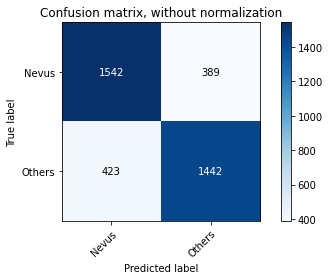

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

2. PCA

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
scaler = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier(n_neighbors=20)
pipeline = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("knn", knn)])
params = {'pca__n_components':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_pca = Pipeline(steps=[("scaler",  StandardScaler()), ("pca", PCA(n_components =  grid_search.best_params_["pca__n_components"])), ("knn", KNeighborsClassifier(n_neighbors=20))])
knn_pca.fit(train_features_all, train_labels)
# Evaluation
y_pred = knn_pca.predict(val_features_all)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Training best_score_ : 0.74125
Best Parameters {'pca__n_components': 75}
Total Time = 10.421264886856079
Scores KNN classifier : {'confusion_matrix': array([[1494,  437],
       [ 407, 1458]]), 'accuracy': 0.7776606954689147, 'kappa': 0.5553091701008105}


3. Model-based selection

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_m = SelectFromModel(lsvc, prefit=False)
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=20)
knn_m_select = Pipeline(steps=[("scaler", scaler), ("selector", selector_m), ("knn", knn)])
# Training
knn_m_select.fit(train_features_all, train_labels)

# Evaluation
y_pred = knn_m_select.predict(val_features_all)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 9.39340090751648
Scores KNN classifier : {'confusion_matrix': array([[1500,  431],
       [ 387, 1478]]), 'accuracy': 0.7845100105374078, 'kappa': 0.5690634448466969}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_kbest' + '.pkl'), 'wb') as f:
        pickle.dump(knn_kbest, f)
print("Model saved..\n")

Model saved..



##### All + Yeo-Johnson

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors=20)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
knn_j = Pipeline(steps=[('pp', transform), ('knn', knn)])
# Training
knn_j.fit(train_features_all, train_labels)
# Evaluation
y_pred = knn_j.predict(val_features_all)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 39.69499230384827
Scores KNN classifier : {'confusion_matrix': array([[1532,  399],
       [ 392, 1473]]), 'accuracy': 0.791622760800843, 'kappa': 0.5831462377545643}


Confusion matrix, without normalization
[[1532  399]
 [ 392 1473]]


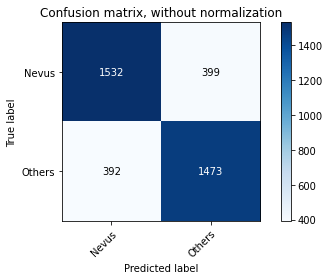

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'knn_j' + '.pkl'), 'wb') as f:
        pickle.dump(knn_j, f)
print("Model saved..\n")

Model saved..



##### Visually chosen feats

In [ ]:
train_features_k = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, [6, 7, 8]], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd[:, 128:], 
                              train_lbp_fd, 
                              train_glcm_fd,
                              train_haralick_fd[:, [3, 6] ]])


val_features_k = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, [6, 7, 8]], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd[:, 128:], 
                            val_lbp_fd, 
                            val_glcm_fd,
                            val_haralick_fd[:, [3, 6] ]])

print(train_features_k.shape)
print(val_features_k.shape)

(15195, 238)
(3796, 238)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors = 20)
scaler = StandardScaler()
knn_lg_k = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
# Training
knn_lg_k.fit(train_features_k, train_labels)
# Evaluation
y_pred = knn_lg_k.predict(val_features_k)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 2.2487833499908447
Scores KNN classifier : {'confusion_matrix': array([[1482,  449],
       [ 374, 1491]]), 'accuracy': 0.7831928345626976, 'kappa': 0.5665524350752957}


Confusion matrix, without normalization
[[1482  449]
 [ 374 1491]]


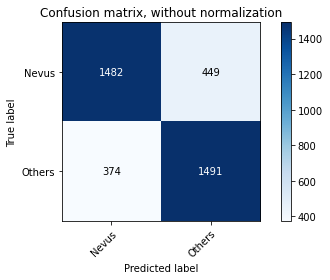

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'knn_k' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_k, f)
print("Model saved..\n")

Model saved..



##### Visuall Yeo-john

In [ ]:
train_features_l = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, 3:], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd, 
                              train_lab_fd, 
                              train_lbp_fd, 
                              train_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])


val_features_l = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, 3:], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd, 
                            val_lab_fd, 
                            val_lbp_fd, 
                            val_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])

print(train_features_l.shape)
print(val_features_l.shape)

(15195, 550)
(3796, 550)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
knn = KNeighborsClassifier(n_neighbors=20)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
knn_l = Pipeline(steps=[('pp', transform), ('knn', knn)])
# Training
knn_l.fit(train_features_l, train_labels)
# Evaluation
y_pred = knn_l.predict(val_features_l)  # Predictions
knn_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 25.5867862701416
Scores KNN classifier : {'confusion_matrix': array([[1541,  390],
       [ 389, 1476]]), 'accuracy': 0.7947839831401475, 'kappa': 0.5894476179475019}


Confusion matrix, without normalization
[[1541  390]
 [ 389 1476]]


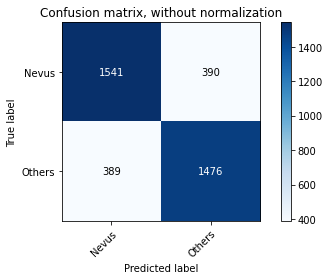

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'knn_l' + '.pkl'), 'wb') as f:
        pickle.dump(knn_l, f)
print("Model saved..\n")

Model saved..



#### XGBoost

##### Fine-tuning

Here we estimate the best values of the parameters of xgboost: n_estimators, max_depth and learning rate, using the small train set and GridSearchCV

In [ ]:
train_features_sm_all = np.hstack([train_variegation_fd_sm, train_color_feature_fd_sm, train_rgb_fd_sm, train_hsv_fd_sm, train_lab_fd_sm, train_lbp_fd_sm, train_haralick_fd_sm, train_glcm_fd_sm])
train_features_all = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_sm_all.shape)
print(train_features_all.shape)
print(val_features_all.shape)

(4000, 642)
(15195, 642)
(3796, 642)


In [ ]:
# TRAIN SUBSET

# Initialize
strt = time.time()
scaler = StandardScaler()
model = xgb.XGBClassifier(objective='binary:logistic')
pipeline = Pipeline(steps=[("scaler", scaler), ("xgb", model)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [3, 5, 7, 9, 13], 'xgb__learning_rate': [0.01, 0.1]} 
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgb_sm_a = grid_search.best_estimator_

# Evaluation
y_pred = xgb_sm_a.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', scores)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training best_score_ : 0.8
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 9, 'xgb__n_estimators': 2000}
Total Time = 16125.286645412445
Scores XGB classifier : {'confusion_matrix': array([[1522,  409],
       [ 350, 1515]]), 'accuracy': 0.8000526870389885, 'kappa': 0.6002005960154992}


In [ ]:
n_estimators = grid_search.best_params_['xgb__n_estimators']
max_depth = grid_search.best_params_['xgb__max_depth']
lr = grid_search.best_params_['xgb__learning_rate']

print(n_estimators)
print(max_depth)
print(lr)

2000
9
0.1


##### Features A (model baseline)

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xgboot = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr)
scaler = StandardScaler()
xgboot_lg_a = Pipeline(steps=[("scaler", scaler), ("xgb", xgboot)])
# training
xgboot_lg_a.fit(train_features_all, train_labels)
# Evaluation
y_pred = xgboot_lg_a.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', scores)

Total Time = 2214.809518098831
Scores XGB classifier : {'confusion_matrix': array([[1639,  292],
       [ 305, 1560]]), 'accuracy': 0.8427291886195996, 'kappa': 0.6853257781557094}


Confusion matrix, without normalization
[[1639  292]
 [ 305 1560]]


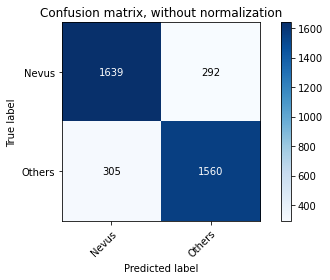

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_a' + '.pkl'), 'wb') as f:
        pickle.dump(xgboot_lg_a, f)
print("Model saved..\n")

Model saved..



##### Features B

In [ ]:
train_features_b = np.hstack([train_variegation_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_b = np.hstack([val_variegation_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_b.shape)
print(val_features_b.shape)

(15195, 630)
(3796, 630)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xgboot = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr)
scaler = StandardScaler()
xgboot_lg_b = Pipeline(steps=[("scaler", scaler), ("xgb", xgboot)])
# Training
xgboot_lg_b.fit(train_features_b, train_labels)
# Evaluation
y_pred = xgboot_lg_b.predict(val_features_b)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', scores)

Total Time = 2089.4376606941223
Scores XGB classifier : {'confusion_matrix': array([[1637,  294],
       [ 325, 1540]]), 'accuracy': 0.8369336143308747, 'kappa': 0.6736759129537271}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_b' + '.pkl'), 'wb') as f:
        pickle.dump(xgboot_lg_b, f)
print("Model saved..\n")

Model saved..



##### Features C

In [ ]:
train_features_c = np.hstack([train_variegation_fd, train_color_feature_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_c = np.hstack([val_variegation_fd, val_color_feature_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_c.shape)
print(val_features_c.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xgboot = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr)
scaler = StandardScaler()
xgboot_lg_c = Pipeline(steps=[("scaler", scaler), ("xgb", xgboot)])
# Training
xgboot_lg_c.fit(train_features_c, train_labels)
# Evaluation
y_pred = xgboot_lg_c.predict(val_features_c)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', scores)

Total Time = 1482.699342250824
Scores XGB classifier : {'confusion_matrix': array([[1643,  288],
       [ 316, 1549]]), 'accuracy': 0.8408851422550052, 'kappa': 0.6815923603853026}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_c' + '.pkl'), 'wb') as f:
        pickle.dump(xgboot_lg_c, f)
print("Model saved..\n")

Model saved..



##### Features D

In [ ]:
train_features_d = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_d = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_d.shape)
print(val_features_d.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xgboot = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr)
scaler = StandardScaler()
xgboot_lg_d = Pipeline(steps=[("scaler", scaler), ("xgb", xgboot)])
# Training
xgboot_lg_d.fit(train_features_d, train_labels)
# Evaluation
y_pred = xgboot_lg_d.predict(val_features_d)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', scores)

Total Time = 1678.5705919265747
Scores XGB classifier : {'confusion_matrix': array([[1633,  298],
       [ 327, 1538]]), 'accuracy': 0.8353530031612223, 'kappa': 0.6705188761784244}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_d' + '.pkl'), 'wb') as f:
        pickle.dump(xgboot_lg_d, f)
print("Model saved..\n")

Model saved..



##### Features E


In [ ]:
train_features_e = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_e = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_e.shape)
print(val_features_e.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xgboot = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr)
scaler = StandardScaler()
xgboot_lg_e = Pipeline(steps=[("scaler", scaler), ("xgb", xgboot)])
# Training
xgboot_lg_e.fit(train_features_e, train_labels)
# Evaluation
y_pred = xgboot_lg_e.predict(val_features_e)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', scores)

Total Time = 1566.9562211036682
Scores XGB classifier : {'confusion_matrix': array([[1618,  313],
       [ 338, 1527]]), 'accuracy': 0.8285036880927292, 'kappa': 0.656825043258001}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_e' + '.pkl'), 'wb') as f:
        pickle.dump(xgboot_lg_e, f)
print("Model saved..\n")

Model saved..



##### Features F

In [ ]:
train_features_f = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd]) 
val_features_f = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd])

In [ ]:
print(train_features_f.shape)
print(val_features_f.shape)

(15195, 591)
(3796, 591)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xgboot = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr)
scaler = StandardScaler()
xgboot_lg_f = Pipeline(steps=[("scaler", scaler), ("xgb", xgboot)])
# Training
xgboot_lg_f.fit(train_features_f, train_labels)
# Evaluation
y_pred = xgboot_lg_f.predict(val_features_f)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', scores)

Total Time = 1955.4885625839233
Scores XGB classifier : {'confusion_matrix': array([[1623,  308],
       [ 348, 1517]]), 'accuracy': 0.827186512118019, 'kappa': 0.6541417418635304}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_f' + '.pkl'), 'wb') as f:
        pickle.dump(xgboot_lg_f, f)
print("Model saved..\n")

Model saved..



##### Features G

In [ ]:
train_features_g = np.hstack([train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_g = np.hstack([val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_g.shape)
print(val_features_g.shape)

(15195, 639)
(3796, 639)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xgboot = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr)
scaler = StandardScaler()
xgboot_lg_g = Pipeline(steps=[("scaler", scaler), ("xgb", xgboot)])
# Training
xgboot_lg_g.fit(train_features_g, train_labels)
# Evaluation
y_pred = xgboot_lg_g.predict(val_features_g)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', scores)

Total Time = 2123.004100561142
Scores XGB classifier : {'confusion_matrix': array([[1632,  299],
       [ 303, 1562]]), 'accuracy': 0.8414120126448894, 'kappa': 0.6827164851105874}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_g' + '.pkl'), 'wb') as f:
        pickle.dump(xgboot_lg_g, f)
print("Model saved..\n")

Model saved..



##### Sklearn Feature selection

1. SelectBest

In [ ]:
strt = time.time()
scaler = StandardScaler()
selector = SelectKBest()

xgboot = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr)
pipeline = Pipeline(steps=[("scaler", scaler), ("selector", selector), ("xgb", xgboot)])
params = {'selector__k':[10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgb_kbest = Pipeline(steps=[("scaler",  StandardScaler()), ("selector", SelectKBest(k =  grid_search.best_params_["selector__k"])), ("xgb",  xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr))])
xgb_kbest.fit(train_features_all, train_labels)
# Evaluation
y_pred = xgb_kbest.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', scores)

Training best_score_ : 0.7855000000000001
Best Parameters {'selector__k': 75}
Total Time = 1457.1286401748657
Scores KNN classifier : {'confusion_matrix': array([[1621,  310],
       [ 350, 1515]]), 'accuracy': 0.8261327713382508, 'kappa': 0.6520328500456251}


2. PCA

In [ ]:
strt = time.time()
scaler = StandardScaler()
pca = PCA()

xgboot = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr)
pipeline = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("xgb", xgboot)])

params = {'pca__n_components':[10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgb_pca = Pipeline(steps=[("scaler",  StandardScaler()), ("pca", PCA(n_components =  grid_search.best_params_["pca__n_components"])), ("xgb",  xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr))])
xgb_pca.fit(train_features_all, train_labels)
# Evaluation
y_pred = xgb_pca.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', scores)

Training best_score_ : 0.7585
Best Parameters {'pca__n_components': 75}
Total Time = 1385.3007335662842
Scores KNN classifier : {'confusion_matrix': array([[1589,  342],
       [ 391, 1474]]), 'accuracy': 0.8069020021074815, 'kappa': 0.6135136892039277}


3. Model-based selection

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_m = SelectFromModel(lsvc, prefit=False)
scaler = StandardScaler()
xgboost = xgb.XGBClassifier(objective='binary:logistic', n_estimators=2000, max_depth=9, learning_rate=0.1)
xgb_m_select = Pipeline(steps=[("scaler", scaler), ("selector", selector_m), ("xgb", xgboost)])
# Training
xgb_m_select.fit(train_features_all, train_labels)

# Evaluation
y_pred = xgb_m_select.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', scores)

Total Time = 486.25031065940857
Scores KNN classifier : {'confusion_matrix': array([[1617,  314],
       [ 323, 1542]]), 'accuracy': 0.8321917808219178, 'kappa': 0.6642543858431144}


Confusion matrix, without normalization
[[1617  314]
 [ 323 1542]]


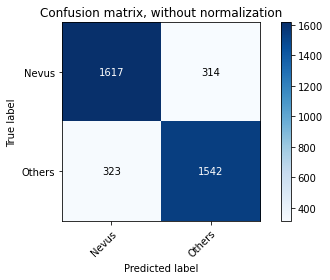

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_i' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_m_select, f)
print("Model saved..\n")

Model saved..



##### All + Yeo-Johnson

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xgboost = xgb.XGBClassifier(objective='binary:logistic', n_estimators=2000, max_depth=9, learning_rate=0.1)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
xgboost_j = Pipeline(steps=[('pp', transform), ('xgboost', xgboost)])

# Training
xgboost_j.fit(train_features_all, train_labels)
# Evaluation
y_pred = xgboost_j.predict(val_features_all)  # Predictions
xgboost_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores xgboost classifier :', xgboost_scores)

Total Time = 1762.0981056690216
Scores xgboost classifier : {'confusion_matrix': array([[1641,  290],
       [ 314, 1551]]), 'accuracy': 0.8408851422550052, 'kappa': 0.6816040336362246}


Confusion matrix, without normalization
[[1641  290]
 [ 314 1551]]


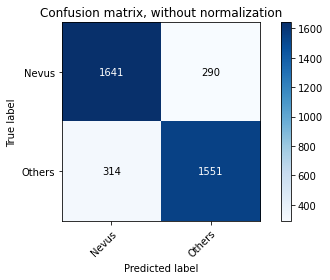

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xgboost_j' + '.pkl'), 'wb') as f:
        pickle.dump(xgboost_j, f)
print("Model saved..\n")

Model saved..



##### Visually chosen feats

In [ ]:
train_features_k = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, [6, 7, 8]], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd[:, 128:], 
                              train_lbp_fd, 
                              train_glcm_fd,
                              train_haralick_fd[:, [3, 6] ]])


val_features_k = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, [6, 7, 8]], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd[:, 128:], 
                            val_lbp_fd, 
                            val_glcm_fd,
                            val_haralick_fd[:, [3, 6] ]])

print(train_features_k.shape)
print(val_features_k.shape)

(15195, 238)
(3796, 238)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xgboost = xgb.XGBClassifier(objective='binary:logistic', n_estimators=2000, max_depth=9, learning_rate=0.1)
scaler = StandardScaler()
xgboost_k = Pipeline(steps=[("scaler", scaler), ("xgboost", xgboost)])
# Training
xgboost_k.fit(train_features_k, train_labels)
# Evaluation
y_pred = xgboost_k.predict(val_features_k)  # Predictions
xgboost_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores xgboost classifier :', xgboost_scores)

Total Time = 816.1146366596222
Scores xgboost classifier : {'confusion_matrix': array([[1590,  341],
       [ 349, 1516]]), 'accuracy': 0.8182297154899895, 'kappa': 0.6363228401930436}


Confusion matrix, without normalization
[[1590  341]
 [ 349 1516]]


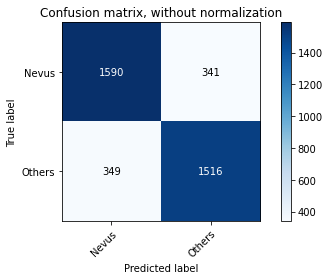

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xgboost_k' + '.pkl'), 'wb') as f:
        pickle.dump(xgboost_k, f)
print("Model saved..\n")

Model saved..



##### Visuall Yeo-john

In [ ]:
train_features_l = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, 3:], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd, 
                              train_lab_fd, 
                              train_lbp_fd, 
                              train_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])


val_features_l = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, 3:], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd, 
                            val_lab_fd, 
                            val_lbp_fd, 
                            val_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])

print(train_features_l.shape)
print(val_features_l.shape)

(15195, 550)
(3796, 550)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xgboost = xgb.XGBClassifier(objective='binary:logistic', n_estimators=2000, max_depth=9, learning_rate=0.1)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
xgboost_l = Pipeline(steps=[('pp', transform), ('xgboost', xgboost)])
# Training
xgboost_l.fit(train_features_l, train_labels)
# Evaluation
y_pred = xgboost_l.predict(val_features_l)  # Predictions
xgboost_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores xgboost classifier :', xgboost_scores)

Total Time = 1486.8632199764252
Scores xgboost classifier : {'confusion_matrix': array([[1638,  293],
       [ 308, 1557]]), 'accuracy': 0.8416754478398314, 'kappa': 0.6832116018018118}


Confusion matrix, without normalization
[[1638  293]
 [ 308 1557]]


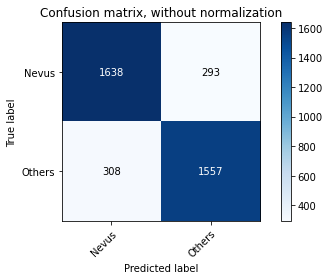

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xgboost_l' + '.pkl'), 'wb') as f:
        pickle.dump(xgboost_l, f)
print("Model saved..\n")

Model saved..



#### SVM

##### Fine-tuning

Here we estimate the best values of the parameter C of SVM, using the small train set and GridSearchCV

In [ ]:
train_features_sm_all = np.hstack([train_variegation_fd_sm, train_color_feature_fd_sm, train_rgb_fd_sm, train_hsv_fd_sm, train_lab_fd_sm, train_lbp_fd_sm, train_haralick_fd_sm, train_glcm_fd_sm])
train_features_all = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_sm_all.shape)
print(train_features_all.shape)
print(val_features_all.shape)

(4000, 642)
(15195, 642)
(3796, 642)


In [ ]:
# TRAIN SUBSET 

# Initialize
strt = time.time()
scaler = StandardScaler()
model = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf')
pipeline = Pipeline(steps=[("scaler", scaler), ("svm", model)])
params = {'svm__C': range(1,11) }  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_sm_a = grid_search.best_estimator_

# Evaluation
y_pred = svm_sm_a.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best_score_ : 0.769
Best Parameters {'svm__C': 8}
Total Time = 1327.143441915512
Scores SVM classifier : {'confusion_matrix': array([[1456,  475],
       [ 386, 1479]]), 'accuracy': 0.7731822971549, 'kappa': 0.5465971857683647}


In [ ]:
c = 8

##### Features A (model baseline)

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
scaler = StandardScaler()
svm_lg_a = Pipeline(steps=[("scaler", scaler), ("svm", svm)])
# Training
svm_lg_a.fit(train_features_all, train_labels)
# Evaluation
y_pred = svm_lg_a.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Total Time = 646.903920173645
Scores classifier : {'confusion_matrix': array([[1580,  351],
       [ 364, 1501]]), 'accuracy': 0.8116438356164384, 'kappa': 0.6231288632853137}


Confusion matrix, without normalization
[[1580  351]
 [ 364 1501]]


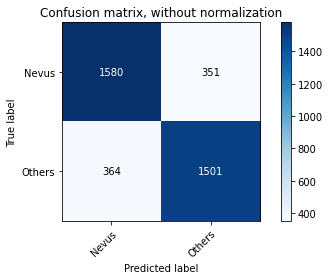

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'svm_a' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_a, f)
print("Model saved..\n")

Model saved..



##### Features B

In [ ]:
train_features_b = np.hstack([train_variegation_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_b = np.hstack([val_variegation_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_b.shape)
print(val_features_b.shape)

(15195, 630)
(3796, 630)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
scaler = StandardScaler()
svm_lg_b = Pipeline(steps=[("scaler", scaler), ("svm", svm)])
# Training
svm_lg_b.fit(train_features_b, train_labels)
# Evaluation
y_pred = svm_lg_b.predict(val_features_b)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Total Time = 660.939817905426
Scores classifier : {'confusion_matrix': array([[1575,  356],
       [ 365, 1500]]), 'accuracy': 0.8100632244467861, 'kappa': 0.6199802389213273}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_b' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_b, f)
print("Model saved..\n")

Model saved..



##### Features C

In [ ]:
train_features_c = np.hstack([train_variegation_fd, train_color_feature_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_c = np.hstack([val_variegation_fd, val_color_feature_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_c.shape)
print(val_features_c.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
scaler = StandardScaler()
svm_lg_c = Pipeline(steps=[("scaler", scaler), ("svm", svm)])
# Training
svm_lg_c.fit(train_features_c, train_labels)
# Evaluation
y_pred = svm_lg_c.predict(val_features_c)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores
end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Total Time = 499.6075415611267
Scores classifier : {'confusion_matrix': array([[1575,  356],
       [ 352, 1513]]), 'accuracy': 0.8134878819810326, 'kappa': 0.6268766415276971}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_c' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_c, f)
print("Model saved..\n")

Model saved..



##### Features D

In [ ]:
train_features_d = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_d = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_d.shape)
print(val_features_d.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
scaler = StandardScaler()
svm_lg_d = Pipeline(steps=[("scaler", scaler), ("svm", svm)])
# Training
svm_lg_d.fit(train_features_d, train_labels)
# Evaluation
y_pred = svm_lg_d.predict(val_features_d)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Total Time = 591.8139071464539
Scores classifier : {'confusion_matrix': array([[1579,  352],
       [ 353, 1512]]), 'accuracy': 0.8142781875658588, 'kappa': 0.6284406497463959}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_d' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_d, f)
print("Model saved..\n")

Model saved..



##### Features E


In [ ]:
train_features_e = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_e = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_e.shape)
print(val_features_e.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
scaler = StandardScaler()
svm_lg_e = Pipeline(steps=[("scaler", scaler), ("svm", svm)])
# Training
svm_lg_e.fit(train_features_e, train_labels)
# Evaluation
y_pred = svm_lg_e.predict(val_features_e)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores
end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Total Time = 479.79436326026917
Scores classifier : {'confusion_matrix': array([[1584,  347],
       [ 378, 1487]]), 'accuracy': 0.8090094836670179, 'kappa': 0.6177948899700358}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_e' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_e, f)
print("Model saved..\n")

Model saved..



##### Features F

In [ ]:
train_features_f = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd]) 
val_features_f = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd])

In [ ]:
print(train_features_f.shape)
print(val_features_f.shape)

(15195, 591)
(3796, 591)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
scaler = StandardScaler()
svm_lg_f = Pipeline(steps=[("scaler", scaler), ("svm", svm)])
# Training
svm_lg_f.fit(train_features_f, train_labels)
# Evaluation
y_pred = svm_lg_f.predict(val_features_f)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores
end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Total Time = 662.8254821300507
Scores classifier : {'confusion_matrix': array([[1551,  380],
       [ 389, 1476]]), 'accuracy': 0.7974183350895679, 'kappa': 0.5946807263945917}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_f' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_f, f)
print("Model saved..\n")

Model saved..



##### Features G

In [ ]:
train_features_g = np.hstack([train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_g = np.hstack([val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_g.shape)
print(val_features_g.shape)

(15195, 639)
(3796, 639)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
scaler = StandardScaler()
svm_lg_g = Pipeline(steps=[("scaler", scaler), ("svm", svm)])
# Training
svm_lg_g.fit(train_features_g, train_labels)
# Evaluation
y_pred = svm_lg_g.predict(val_features_g)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Total Time = 702.2944617271423
Scores classifier : {'confusion_matrix': array([[1579,  352],
       [ 366, 1499]]), 'accuracy': 0.8108535300316122, 'kappa': 0.6215441174632789}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_g' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_g, f)
print("Model saved..\n")

Model saved..



##### Features H

In [ ]:
train_features_h = np.hstack([train_color_feature_fd, train_variegation_fd, train_hsv_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_h = np.hstack([val_color_feature_fd, val_variegation_fd, val_hsv_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_h.shape)
print(val_features_h.shape)

(15195, 258)
(3796, 258)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
scaler = StandardScaler()
svm_lg_h = Pipeline(steps=[("scaler", scaler), ("svm", svm)])
# Training
svm_lg_h.fit(train_features_h, train_labels)
# Evaluation
y_pred = svm_lg_h.predict(val_features_h)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 221.2205572128296
Scores : {'confusion_matrix': array([[1582,  349],
       [ 332, 1533]]), 'accuracy': 0.8206006322444679, 'kappa': 0.6411486680829657}


Confusion matrix, without normalization
[[1582  349]
 [ 332 1533]]


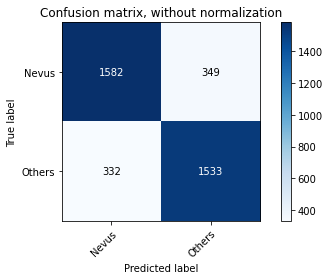

In [ ]:
with open(os.path.join(save_path, 'models', 'svm_h' + '.pkl'), 'rb') as file:
    xgboost_j = pickle.load(file)

y_pred = xgboost_j.predict(val_features_h)

plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'svm_h' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_h, f)
print("Model saved..\n")

Model saved..



##### Sklearn Feature selection

1. SelectBest

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
scaler = StandardScaler()
selector = SelectKBest()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
pipeline = Pipeline(steps=[("scaler", scaler), ("selector", selector), ("svc", svm)])
params = {'selector__k':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_kbest = Pipeline(steps=[("scaler",  StandardScaler()), ("selector", SelectKBest(k =  grid_search.best_params_["selector__k"])), ("svm", SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c))])
svm_kbest.fit(train_features_all, train_labels)
# Evaluation
y_pred = svm_kbest.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', scores)

Training best_score_ : 0.7825
Best Parameters {'selector__k': 75}
Total Time = 243.81649923324585
Scores KNN classifier : {'confusion_matrix': array([[1588,  343],
       [ 363, 1502]]), 'accuracy': 0.8140147523709168, 'kappa': 0.6278488219504507}


2. PCA

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
scaler = StandardScaler()
pca = PCA()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
pipeline = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("svm", svm)])
params = {'pca__n_components':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_pca = Pipeline(steps=[("scaler",  StandardScaler()), ("pca", PCA(n_components =  grid_search.best_params_["pca__n_components"])), ("svm", SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c))])
svm_pca.fit(train_features_all, train_labels)
# Evaluation
y_pred = svm_pca.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Training best_score_ : 0.7452500000000001
Best Parameters {'pca__n_components': 100}
Total Time = 464.7281370162964
Scores : {'confusion_matrix': array([[1590,  341],
       [ 420, 1445]]), 'accuracy': 0.7995258166491043, 'kappa': 0.5986398451888844}


3. Model-based selection

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = 1000, criterion= 'gini', max_depth = 13)
selector_m = SelectFromModel(rf, prefit=False)
scaler = StandardScaler()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = c)
svm_m_select = Pipeline(steps=[("scaler", scaler), ("selector", selector_m), ("svm", svm)])
# Training
svm_m_select.fit(train_features_all, train_labels)

# Evaluation
y_pred = svm_m_select.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 412.90430092811584
Scores : {'confusion_matrix': array([[1585,  346],
       [ 347, 1518]]), 'accuracy': 0.8174394099051633, 'kappa': 0.6347650642187976}


Confusion matrix, without normalization
[[1585  346]
 [ 347 1518]]


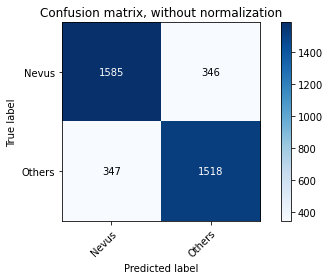

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'svm_skl' + '.pkl'), 'wb') as f:
        pickle.dump(svm_m_select, f)
print("Model saved..\n")

Model saved..



##### All + Yeo-Johnson

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = 8)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
svm_j = Pipeline(steps=[('pp', transform), ('svm', svm)])
# Training
svm_j.fit(train_features_all, train_labels)
# Evaluation
y_pred = svm_j.predict(val_features_all)  # Predictions
svm_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores svm classifier :', svm_scores)

Total Time = 384.8395690917969
Scores svm classifier : {'confusion_matrix': array([[1615,  316],
       [ 307, 1558]]), 'accuracy': 0.8358798735511064, 'kappa': 0.6716875665674148}


Confusion matrix, without normalization
[[1615  316]
 [ 307 1558]]


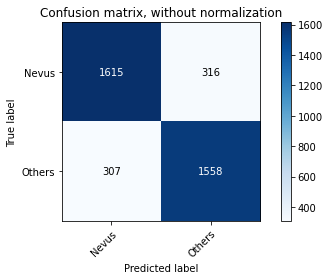

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'svm_j' + '.pkl'), 'wb') as f:
        pickle.dump(svm_j, f)
print("Model saved..\n")

Model saved..



##### Visually chosen feats

In [ ]:
train_features_k = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, [6, 7, 8]], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd[:, 128:], 
                              train_lbp_fd, 
                              train_glcm_fd,
                              train_haralick_fd[:, [3, 6] ]])


val_features_k = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, [6, 7, 8]], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd[:, 128:], 
                            val_lbp_fd, 
                            val_glcm_fd,
                            val_haralick_fd[:, [3, 6] ]])

print(train_features_k.shape)
print(val_features_k.shape)

(15195, 238)
(3796, 238)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = 8)
scaler = StandardScaler()
svm_k = Pipeline(steps=[("scaler", scaler), ("svm", svm)])
# Training
svm_k.fit(train_features_k, train_labels)
# Evaluation
y_pred = svm_k.predict(val_features_k)  # Predictions
svm_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores svm classifier :', svm_scores)

Total Time = 150.37041091918945
Scores svm classifier : {'confusion_matrix': array([[1569,  362],
       [ 393, 1472]]), 'accuracy': 0.8011064278187566, 'kappa': 0.6019795061067269}


Confusion matrix, without normalization
[[1569  362]
 [ 393 1472]]


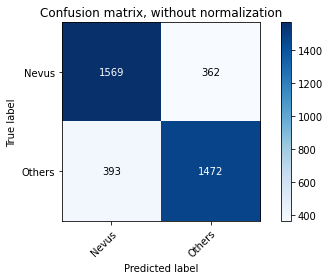

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'svm_k' + '.pkl'), 'wb') as f:
        pickle.dump(svm_k, f)
print("Model saved..\n")

Model saved..



##### Visuall Yeo-john

In [ ]:
train_features_l = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, 3:], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd, 
                              train_lab_fd, 
                              train_lbp_fd, 
                              train_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])


val_features_l = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, 3:], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd, 
                            val_lab_fd, 
                            val_lbp_fd, 
                            val_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])

print(train_features_l.shape)
print(val_features_l.shape)

(15195, 550)
(3796, 550)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = 8)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
svm_l = Pipeline(steps=[('pp', transform), ('svm', svm)])
# Training
svm_l.fit(train_features_l, train_labels)
# Evaluation
y_pred = svm_l.predict(val_features_l)  # Predictions
svm_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores svm classifier :', svm_scores)

Total Time = 318.782776594162
Scores svm classifier : {'confusion_matrix': array([[1613,  318],
       [ 305, 1560]]), 'accuracy': 0.8358798735511064, 'kappa': 0.6716995988609962}


Confusion matrix, without normalization
[[1613  318]
 [ 305 1560]]


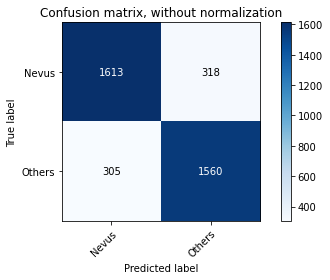

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'svm_l' + '.pkl'), 'wb') as f:
        pickle.dump(svm_l, f)
print("Model saved..\n")

Model saved..



#### Random Forest

##### Fine-tuning

Here we estimate the best values of the parameters of RandomForest: n_estimators, max_depth and criterion, using the small train set and GridSearchCV.

In [ ]:
train_features_sm_all = np.hstack([train_variegation_fd_sm, train_color_feature_fd_sm, train_rgb_fd_sm, train_hsv_fd_sm, train_lab_fd_sm, train_lbp_fd_sm, train_haralick_fd_sm, train_glcm_fd_sm])
train_features_all = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_sm_all.shape)
print(train_features_all.shape)
print(val_features_all.shape)

(4000, 642)
(15195, 642)
(3796, 642)


In [ ]:
# TRAIN SUBSET

# Initialize
strt = time.time()
scaler = StandardScaler()
model = RandomForestClassifier() 
pipeline = Pipeline(steps=[("scaler", scaler), ("rf", model)])
params = {'rf__n_estimators':[50, 100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [5, 7, 9, 13, 20, 30]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_sm_a = grid_search.best_estimator_

# Evaluation
y_pred = rf_sm_a.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', scores)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Training best_score_ : 0.7887500000000001
Best Parameters {'rf__criterion': 'gini', 'rf__max_depth': 20, 'rf__n_estimators': 500}
Total Time = 5708.595619678497
Scores KNN classifier : {'confusion_matrix': array([[1611,  320],
       [ 434, 1431]]), 'accuracy': 0.8013698630136986, 'kappa': 0.6022040536998343}


In [ ]:
n_estims =  grid_search.best_params_['rf__n_estimators']
criter = grid_search.best_params_['rf__criterion']
max_dep = grid_search.best_params_['rf__max_depth']

##### Features A

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
rf_lg_a = Pipeline(steps=[("scaler", scaler), ("rf", rf)])
# Training
rf_lg_a.fit(train_features_all, train_labels)
# Evaluation
y_pred = rf_lg_a.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 135.67473220825195
Scores : {'confusion_matrix': array([[1637,  294],
       [ 358, 1507]]), 'accuracy': 0.8282402528977871, 'kappa': 0.6561749920746343}


Confusion matrix, without normalization
[[1637  294]
 [ 358 1507]]


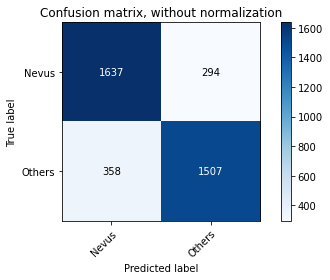

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'rf_a' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_a, f)
print("Model saved..\n")

Model saved..



##### Features B

In [ ]:
train_features_b = np.hstack([train_variegation_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_b = np.hstack([val_variegation_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_b.shape)
print(val_features_b.shape)

(15195, 630)
(3796, 630)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
rf_lg_b = Pipeline(steps=[("scaler", scaler), ("rf", rf)])
# Training
rf_lg_b.fit(train_features_b, train_labels)
# Evaluation
y_pred = rf_lg_b.predict(val_features_b)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', scores)

Total Time = 134.78998851776123
Scores KNN classifier : {'confusion_matrix': array([[1632,  299],
       [ 374, 1491]]), 'accuracy': 0.8227081138040042, 'kappa': 0.6450650765246579}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_b' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_b, f)
print("Model saved..\n")

Model saved..



##### Features C

In [ ]:
train_features_c = np.hstack([train_variegation_fd, train_color_feature_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_c = np.hstack([val_variegation_fd, val_color_feature_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_c.shape)
print(val_features_c.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
rf_lg_c = Pipeline(steps=[("scaler", scaler), ("rf", rf)])
# Training
rf_lg_c.fit(train_features_c, train_labels)
# Evaluation
y_pred = rf_lg_c.predict(val_features_c)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 108.51370882987976
Scores : {'confusion_matrix': array([[1628,  303],
       [ 362, 1503]]), 'accuracy': 0.8248155953635405, 'kappa': 0.6493356611494018}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_c' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_c, f)
print("Model saved..\n")

Model saved..



##### Features D

In [ ]:
train_features_d = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_d = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_d.shape)
print(val_features_d.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
rf_lg_d = Pipeline(steps=[("scaler", scaler), ("rf", rf)])
# Training
rf_lg_d.fit(train_features_d, train_labels)
# Evaluation
y_pred = rf_lg_d.predict(val_features_d)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 132.2291932106018
Scores : {'confusion_matrix': array([[1637,  294],
       [ 371, 1494]]), 'accuracy': 0.8248155953635405, 'kappa': 0.6492777818223651}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_d' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_d, f)
print("Model saved..\n")

Model saved..



##### Features E


In [ ]:
train_features_e = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_e = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_e.shape)
print(val_features_e.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
rf_lg_e = Pipeline(steps=[("scaler", scaler), ("rf", rf)])
# Training
rf_lg_e.fit(train_features_e, train_labels)
# Evaluation
y_pred = rf_lg_e.predict(val_features_e)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 106.92955446243286
Scores : {'confusion_matrix': array([[1612,  319],
       [ 361, 1504]]), 'accuracy': 0.8208640674394099, 'kappa': 0.641481818113635}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_e' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_e, f)
print("Model saved..\n")

Model saved..



##### Features F

In [ ]:
train_features_f = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd]) 
val_features_f = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd])

In [ ]:
print(train_features_f.shape)
print(val_features_f.shape)

(15195, 591)
(3796, 591)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
rf_lg_f = Pipeline(steps=[("scaler", scaler), ("rf", rf)])
# Training
rf_lg_f.fit(train_features_f, train_labels)
# Evaluation
y_pred = rf_lg_f.predict(val_features_f)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 123.30963921546936
Scores : {'confusion_matrix': array([[1630,  301],
       [ 393, 1472]]), 'accuracy': 0.8171759747102213, 'kappa': 0.6339327773082633}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_f' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_f, f)
print("Model saved..\n")

Model saved..



##### Features G

In [ ]:
train_features_g = np.hstack([train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_g = np.hstack([val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_g.shape)
print(val_features_g.shape)

(15195, 639)
(3796, 639)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = 1000, criterion='gini', max_depth = 20)
scaler = StandardScaler()
rf_lg_g = Pipeline(steps=[("scaler", scaler), ("rf", rf)])
# Training
rf_lg_g.fit(train_features_g, train_labels)
# Evaluation
y_pred = rf_lg_g.predict(val_features_g)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 309.55564308166504
Scores : {'confusion_matrix': array([[1635,  296],
       [ 369, 1496]]), 'accuracy': 0.8248155953635405, 'kappa': 0.6492906455461743}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_g' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_g, f)
print("Model saved..\n")

Model saved..



##### Sklearn Feature selection

1. SelectBest

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
scaler = StandardScaler()
selector = SelectKBest()
rf = RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
pipeline = Pipeline(steps=[("scaler", scaler), ("selector", selector), ("rf", rf)])
params = {'selector__k':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_kbest = Pipeline(steps=[("scaler",  StandardScaler()), ("selector", SelectKBest(k =  grid_search.best_params_["selector__k"])), ("rf",  RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep))])
rf_kbest.fit(train_features_all, train_labels)
# Evaluation
y_pred = rf_kbest.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Training best_score_ : 0.777
Best Parameters {'selector__k': 75}
Total Time = 343.96776723861694
Scores classifier : {'confusion_matrix': array([[1627,  304],
       [ 384, 1481]]), 'accuracy': 0.8187565858798735, 'kappa': 0.6371375575732735}


Confusion matrix, without normalization
[[1627  304]
 [ 384 1481]]


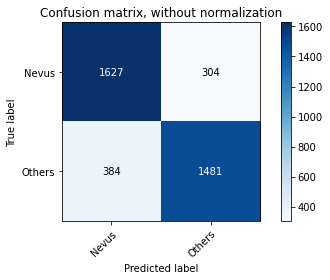

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

2. PCA

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
scaler = StandardScaler()
pca = PCA()
rf = RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
pipeline = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("rf", rf)])
params = {'pca__n_components':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_pca = Pipeline(steps=[("scaler",  StandardScaler()), ("pca", PCA(n_components =  grid_search.best_params_["pca__n_components"])), ("rf", RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep))])
rf_pca.fit(train_features_all, train_labels)
# Evaluation
y_pred = rf_pca.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', scores)

Training best_score_ : 0.7592500000000001
Best Parameters {'pca__n_components': 100}
Total Time = 382.6635932922363
Scores KNN classifier : {'confusion_matrix': array([[1601,  330],
       [ 434, 1431]]), 'accuracy': 0.7987355110642782, 'kappa': 0.5969652153780431}


3. Model-Based Selection

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_m = SelectFromModel(lsvc, prefit=False)
scaler = StandardScaler()
rf = RandomForestClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
rf_m_select = Pipeline(steps=[("scaler", scaler), ("selector", selector_m), ("rf", rf)])
# Training
rf_m_select.fit(train_features_h, train_labels)

# Evaluation
y_pred = rf_m_select.predict(val_features_h)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 67.5580747127533
Scores : {'confusion_matrix': array([[1623,  308],
       [ 394, 1471]]), 'accuracy': 0.815068493150685, 'kappa': 0.6297333566394894}


##### All + Yeo-Johnson

In [ ]:
strt = time.time() 
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = 500, criterion='gini', max_depth = 20)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
rf_j = Pipeline(steps=[('pp', transform), ('rf', rf)])
# Training
rf_j.fit(train_features_all, train_labels)
#Evaluation
y_pred = rf_j.predict(val_features_all)  # Predictions
rf_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores rf classifier :', rf_scores)

Total Time = 162.6276228427887
Scores rf classifier : {'confusion_matrix': array([[1639,  292],
       [ 361, 1504]]), 'accuracy': 0.8279768177028451, 'kappa': 0.6556318660708778}


Confusion matrix, without normalization
[[1639  292]
 [ 361 1504]]


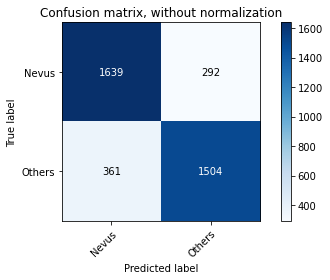

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'rf_j' + '.pkl'), 'wb') as f:
        pickle.dump(rf_j, f)
print("Model saved..\n")

Model saved..



##### Visually chosen feats

In [ ]:
train_features_k = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, [6, 7, 8]], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd[:, 128:], 
                              train_lbp_fd, 
                              train_glcm_fd,
                              train_haralick_fd[:, [3, 6] ]])


val_features_k = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, [6, 7, 8]], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd[:, 128:], 
                            val_lbp_fd, 
                            val_glcm_fd,
                            val_haralick_fd[:, [3, 6] ]])

print(train_features_k.shape)
print(val_features_k.shape)

(15195, 238)
(3796, 238)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = 500, criterion='gini', max_depth = 20)
scaler = StandardScaler()
rf_k = Pipeline(steps=[("scaler", scaler), ("rf", rf)])
# Training
rf_k.fit(train_features_k, train_labels)
# Evaluation
y_pred = rf_k.predict(val_features_k)  # Predictions
rf_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores rf classifier :', rf_scores)

Total Time = 98.40807437896729
Scores rf classifier : {'confusion_matrix': array([[1607,  324],
       [ 358, 1507]]), 'accuracy': 0.8203371970495258, 'kappa': 0.6404537201200047}


Confusion matrix, without normalization
[[1607  324]
 [ 358 1507]]


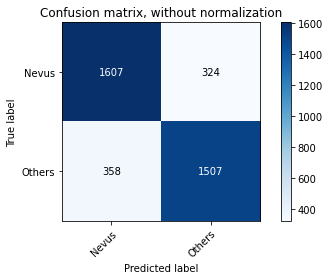

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'rf_k' + '.pkl'), 'wb') as f:
        pickle.dump(rf_k, f)
print("Model saved..\n")

Model saved..



##### Visuall Yeo-john

In [ ]:
train_features_l = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, 3:], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd, 
                              train_lab_fd, 
                              train_lbp_fd, 
                              train_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])


val_features_l = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, 3:], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd, 
                            val_lab_fd, 
                            val_lbp_fd, 
                            val_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])

print(train_features_l.shape)
print(val_features_l.shape)

(15195, 550)
(3796, 550)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
rf = RandomForestClassifier(n_estimators = 500, criterion='gini', max_depth = 20)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
rf_l = Pipeline(steps=[('pp', transform), ('rf', rf)])
# Training
rf_l.fit(train_features_l, train_labels)
# Evaluation
y_pred = rf_l.predict(val_features_l)  # Predictions
rf_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores rf classifier :', rf_scores)

Total Time = 150.1807734966278
Scores rf classifier : {'confusion_matrix': array([[1642,  289],
       [ 374, 1491]]), 'accuracy': 0.8253424657534246, 'kappa': 0.6503069325915449}


Confusion matrix, without normalization
[[1628  303]
 [ 369 1496]]


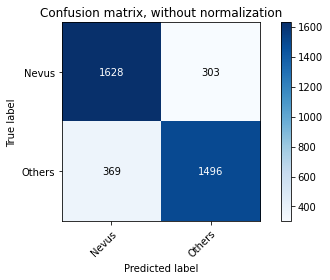

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'rf_l' + '.pkl'), 'wb') as f:
        pickle.dump(rf_l, f)
print("Model saved..\n")

Model saved..



#### XTrees

##### Fine-tuning

Here we estimate the best values of the parameters of ExtraTreeClassifier: n_estimators, max_depth and criterion, using the small train set and GridSearchCV

In [ ]:
train_features_sm_all = np.hstack([train_variegation_fd_sm, train_color_feature_fd_sm, train_rgb_fd_sm, train_hsv_fd_sm, train_lab_fd_sm, train_lbp_fd_sm, train_haralick_fd_sm, train_glcm_fd_sm])
train_features_all = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_sm_all.shape)
print(train_features_all.shape)
print(val_features_all.shape)

(4000, 642)
(15195, 642)
(3796, 642)


In [ ]:
# TRAIN SUBSET

# Initialize
strt = time.time()
scaler = StandardScaler()
model = ExtraTreesClassifier() 
pipeline = Pipeline(steps=[("scaler", scaler), ("xtree", model)])
params = {'xtree__n_estimators':[50, 100, 500, 1000, 2000], 'xtree__criterion' : ['entropy','gini'], 'xtree__max_depth': [7, 9, 13, 20, 40]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_sm_a = grid_search.best_estimator_

# Evaluation
y_pred = xtree_sm_a.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training best_score_ : 0.786
Best Parameters {'xtree__criterion': 'gini', 'xtree__max_depth': 40, 'xtree__n_estimators': 500}
Total Time = 1934.9533367156982
Scores : {'confusion_matrix': array([[1582,  349],
       [ 408, 1457]]), 'accuracy': 0.8005795574288725, 'kappa': 0.6008226999851085}


In [ ]:
n_estims =  grid_search.best_params_['xtree__n_estimators']
criter = grid_search.best_params_['xtree__criterion']
max_dep = grid_search.best_params_['xtree__max_depth']

print(n_estims)
print(criter)
print(max_dep)

500
gini
40


##### Features A

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xtree = ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
xtree_lg_a = Pipeline(steps=[("scaler", scaler), ("xtree", xtree)])
# Training
xtree_lg_a.fit(train_features_all, train_labels)
# Evaluation
y_pred = xtree_lg_a.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 76.97491788864136
Scores : {'confusion_matrix': array([[1633,  298],
       [ 351, 1514]]), 'accuracy': 0.8290305584826133, 'kappa': 0.6577915226446744}


Confusion matrix, without normalization
[[1633  298]
 [ 351 1514]]


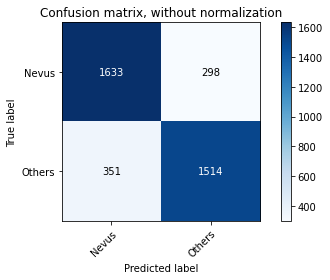

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_a' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_lg_a, f)
print("Model saved..\n")

Model saved..



##### Features B

In [ ]:
train_features_b = np.hstack([train_variegation_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_b = np.hstack([val_variegation_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_b.shape)
print(val_features_b.shape)

(15195, 630)
(3796, 630)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xtree = ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
xtree_lg_b = Pipeline(steps=[("scaler", scaler), ("xtree", xtree)])
# Training
xtree_lg_b.fit(train_features_b, train_labels)
# Evaluation
y_pred = xtree_lg_b.predict(val_features_b)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 44.71826934814453
Scores : {'confusion_matrix': array([[1627,  304],
       [ 350, 1515]]), 'accuracy': 0.827713382507903, 'kappa': 0.6551772224933795}


In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_b' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_lg_b, f)
print("Model saved..\n")

Model saved..



##### Features C

In [ ]:
train_features_c = np.hstack([train_variegation_fd, train_color_feature_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_c = np.hstack([val_variegation_fd, val_color_feature_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_c.shape)
print(val_features_c.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xtree = ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
xtree_lg_c = Pipeline(steps=[("scaler", scaler), ("xtree", xtree)])
# Training
xtree_lg_c.fit(train_features_c, train_labels)
# Evaluation
y_pred = xtree_lg_c.predict(val_features_c)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 33.16428565979004
Scores : {'confusion_matrix': array([[1633,  298],
       [ 356, 1509]]), 'accuracy': 0.827713382507903, 'kappa': 0.6551392856755889}


In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_c' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_lg_c, f)
print("Model saved..\n")

Model saved..



##### Features D

In [ ]:
train_features_d = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_d = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_d.shape)
print(val_features_d.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xtree = ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
xtree_lg_d = Pipeline(steps=[("scaler", scaler), ("xtree", xtree)])
# Training
xtree_lg_d.fit(train_features_d, train_labels)
# Evaluation
y_pred = xtree_lg_d.predict(val_features_d)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 38.45908546447754
Scores : {'confusion_matrix': array([[1637,  294],
       [ 360, 1505]]), 'accuracy': 0.827713382507903, 'kappa': 0.6551139898258944}


In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_d' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_lg_d, f)
print("Model saved..\n")

Model saved..



##### Features E


In [ ]:
train_features_e = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_e = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_e.shape)
print(val_features_e.shape)

(15195, 450)
(3796, 450)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xtree = ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
xtree_lg_e = Pipeline(steps=[("scaler", scaler), ("xtree", xtree)])
# Training
xtree_lg_e.fit(train_features_e, train_labels)
# Evaluation
y_pred = xtree_lg_e.predict(val_features_e)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 42.8353271484375
Scores : {'confusion_matrix': array([[1607,  324],
       [ 353, 1512]]), 'accuracy': 0.821654373024236, 'kappa': 0.6431060466764694}


In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_e' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_lg_e, f)
print("Model saved..\n")

Model saved..



##### Features F

In [ ]:
train_features_f = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd]) 
val_features_f = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd])

In [ ]:
print(train_features_f.shape)
print(val_features_f.shape)

(15195, 591)
(3796, 591)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xtree = ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
xtree_lg_f = Pipeline(steps=[("scaler", scaler), ("xtree", xtree)])
# Training
xtree_lg_f.fit(train_features_f, train_labels)
# Evaluation
y_pred = xtree_lg_f.predict(val_features_f)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 40.35941195487976
Scores : {'confusion_matrix': array([[1599,  332],
       [ 382, 1483]]), 'accuracy': 0.8119072708113804, 'kappa': 0.6235283005501902}


In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_f' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_lg_f, f)
print("Model saved..\n")

Model saved..



##### Features G

In [ ]:
train_features_g = np.hstack([train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_g = np.hstack([val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

In [ ]:
print(train_features_g.shape)
print(val_features_g.shape)

(15195, 639)
(3796, 639)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xtree = ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
scaler = StandardScaler()
xtree_lg_g = Pipeline(steps=[("scaler", scaler), ("xtree", xtree)])
# Training
xtree_lg_g.fit(train_features_g, train_labels)
# Evaluation
y_pred = xtree_lg_g.predict(val_features_g)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 42.41122603416443
Scores : {'confusion_matrix': array([[1636,  295],
       [ 358, 1507]]), 'accuracy': 0.8279768177028451, 'kappa': 0.6556508103386385}


In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_g' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_lg_g, f)
print("Model saved..\n")

Model saved..



##### Sklearn Feature selection

1. SelectBest

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
scaler = StandardScaler()
selector = SelectKBest()
xtree = ExtraTreesClassifier(n_estimators = 500, criterion='gini', max_depth = 40)
pipeline = Pipeline(steps=[("scaler", scaler), ("selector", selector), ("xtree", xtree)])
params = {'selector__k':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_kbest = Pipeline(steps=[("scaler",  StandardScaler()), ("selector", SelectKBest(k =  grid_search.best_params_["selector__k"])), ("xtree",  ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep))])
xtree_kbest.fit(train_features_all, train_labels)
# Evaluation
y_pred = xtree_kbest.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Training best_score_ : 0.78075
Best Parameters {'selector__k': 100}
Total Time = 124.97825622558594
Scores classifier : {'confusion_matrix': array([[1618,  313],
       [ 360, 1505]]), 'accuracy': 0.8227081138040042, 'kappa': 0.6451561824608503}


Confusion matrix, without normalization
[[1618  313]
 [ 360 1505]]


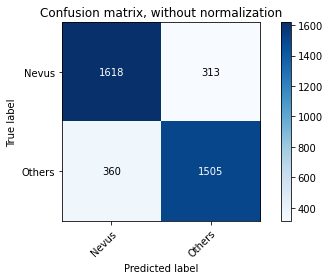

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_kbest' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_kbest, f)
print("Model saved..\n")

Model saved..



2. PCA

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
scaler = StandardScaler()
pca = PCA()
xtree = ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
pipeline = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("xtree", xtree)])
params = {'pca__n_components':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm_all, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_pca = Pipeline(steps=[("scaler",  StandardScaler()), ("pca", PCA(n_components =  grid_search.best_params_["pca__n_components"])), ("xtree", ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep))])
xtree_pca.fit(train_features_all, train_labels)
# Evaluation
y_pred = xtree_pca.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', scores)

Training best_score_ : 0.7645
Best Parameters {'pca__n_components': 75}
Total Time = 128.69232296943665
Scores KNN classifier : {'confusion_matrix': array([[1610,  321],
       [ 401, 1464]]), 'accuracy': 0.809799789251844, 'kappa': 0.6192054019882318}


3. Model-based selection

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_m = SelectFromModel(lsvc, prefit=False)
scaler = StandardScaler()
xtree = ExtraTreesClassifier(n_estimators = n_estims, criterion=criter, max_depth = max_dep)
xtree_m_select = Pipeline(steps=[("scaler", scaler), ("selector", selector_m), ("xtree", xtree)])
# Training
xtree_m_select.fit(train_features_all, train_labels)

# Evaluation
y_pred = xtree_m_select.predict(val_features_all)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores :', scores)

Total Time = 58.63400077819824
Scores : {'confusion_matrix': array([[1617,  314],
       [ 365, 1500]]), 'accuracy': 0.821127502634352, 'kappa': 0.641979513461376}


##### All + Yeo-Johnson

In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xtree = ExtraTreesClassifier(n_estimators = 500, criterion='gini', max_depth = 40)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
xtree_j = Pipeline(steps=[('pp', transform), ('xtree', xtree)])
# Training
xtree_j.fit(train_features_all, train_labels)
#Eval
y_pred = xtree_j.predict(val_features_all)  # Predictions
xtree_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores xtree classifier :', xtree_scores)

Total Time = 80.91322350502014
Scores xtree classifier : {'confusion_matrix': array([[1639,  292],
       [ 343, 1522]]), 'accuracy': 0.8327186512118019, 'kappa': 0.6651796628099762}


Confusion matrix, without normalization
[[1639  292]
 [ 343 1522]]


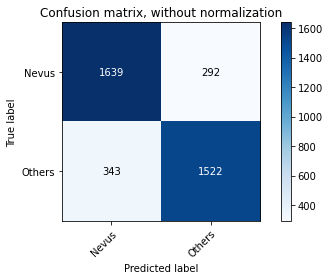

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_j' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_j, f)
print("Model saved..\n")

Model saved..



##### Visually chosen feats

In [ ]:
train_features_k = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, [6, 7, 8]], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd[:, 128:], 
                              train_lbp_fd, 
                              train_glcm_fd,
                              train_haralick_fd[:, [3, 6] ]])


val_features_k = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, [6, 7, 8]], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd[:, 128:], 
                            val_lbp_fd, 
                            val_glcm_fd,
                            val_haralick_fd[:, [3, 6] ]])

print(train_features_k.shape)
print(val_features_k.shape)

(15195, 238)
(3796, 238)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xtree = ExtraTreesClassifier(n_estimators = 500, criterion='gini', max_depth = 40)
scaler = StandardScaler()
xtree_k = Pipeline(steps=[("scaler", scaler), ("xtree", xtree)])
# Training
xtree_k.fit(train_features_k, train_labels)
# Evaluation
y_pred = xtree_k.predict(val_features_k)  # Predictions
xtree_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores xtree classifier :', xtree_scores)

Total Time = 41.45015549659729
Scores xtree classifier : {'confusion_matrix': array([[1595,  336],
       [ 360, 1505]]), 'accuracy': 0.8166491043203372, 'kappa': 0.633106634786113}


Confusion matrix, without normalization
[[1595  336]
 [ 360 1505]]


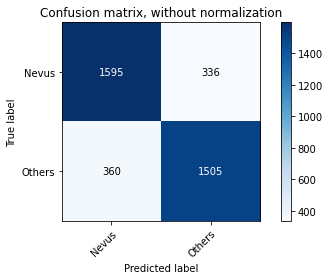

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_k' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_k, f)
print("Model saved..\n")

Model saved..



##### Visuall Yeo-john

In [ ]:
train_features_l = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, 3:], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd, 
                              train_lab_fd, 
                              train_lbp_fd, 
                              train_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])


val_features_l = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, 3:], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd, 
                            val_lab_fd, 
                            val_lbp_fd, 
                            val_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])

print(train_features_l.shape)
print(val_features_l.shape)

(15195, 550)
(3796, 550)


In [ ]:
strt = time.time()
# preprocessing and model pipeline initialization
xtree = ExtraTreesClassifier(n_estimators = 500, criterion='gini', max_depth = 40)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
xtree_l = Pipeline(steps=[('pp', transform), ('xtree', xtree)])
# Training
xtree_l.fit(train_features_l, train_labels)
# eval
y_pred = xtree_l.predict(val_features_l)  # Predictions
xtree_scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores xtree classifier :', xtree_scores)

Total Time = 66.93810606002808
Scores xtree classifier : {'confusion_matrix': array([[1643,  288],
       [ 349, 1516]]), 'accuracy': 0.8321917808219178, 'kappa': 0.6640943160646147}


Confusion matrix, without normalization
[[1643  288]
 [ 349 1516]]


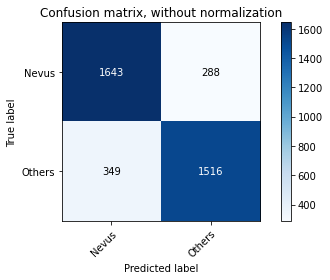

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xtree_l' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_l, f)
print("Model saved..\n")

Model saved..



#### Ensembles 


In this section we try to train ensembles (using sklearn StackingClassifier and VotingClassifier)

In [ ]:
# Features 
train_features = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, 3:], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd, 
                              train_lab_fd, 
                              train_lbp_fd, 
                              train_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])


val_features = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, 3:], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd, 
                            val_lab_fd, 
                            val_lbp_fd, 
                            val_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])

In [ ]:
# models
knn = KNeighborsClassifier(n_neighbors=20)
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = 8)
rf = RandomForestClassifier(n_estimators = 500, criterion='gini', max_depth = 20)
xgboost = xgb.XGBClassifier(objective='binary:logistic', n_estimators=2000, max_depth=9, learning_rate=0.1)
xtree = ExtraTreesClassifier(n_estimators = 500, criterion='gini', max_depth = 40)

##### Stacking

In [ ]:
meta_model = linear_model.LogisticRegression()

In [ ]:
estimators = [
    ('svm', svm),
    ('xtree', xtree),
    ('xgboost', xgboost)
 ]

In [ ]:
# Training 
strt = time.time()
stacked = StackingClassifier( estimators=estimators, final_estimator= meta_model)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
stacking_pipe = Pipeline(steps=[('pp', transform), ('model', stacked)])
# Training
stacking_pipe.fit(train_features, train_labels)
# Evaluation
y_pred = stacking_pipe.predict(val_features)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores
end = time.time()
print('Time :', (end-strt))
print('Scores classifier :', scores)

Time : 10339.709465503693
Scores classifier : {'confusion_matrix': array([[1626,  305],
       [ 301, 1564]]), 'accuracy': 0.8403582718651211, 'kappa': 0.6806317016465881}


In [ ]:
with open(os.path.join(save_path, 'models', 'stacking_pipe' + '.pkl'), 'wb') as f:
        pickle.dump(stacking_pipe, f)
print("Model saved..\n")

Model saved..



Confusion matrix, without normalization
[[1626  305]
 [ 301 1564]]


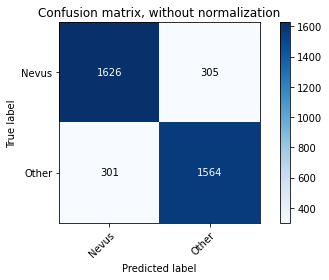

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Other'])

##### Voting (SOFT)

In [ ]:
estimators = [
    ('xtree', xtree),
    ('svm', svm),
    ('xgboost', xgboost),
 ]

strt = time.time()
voter = VotingClassifier( estimators=estimators, voting = 'soft' )
transform = PowerTransformer(method='yeo-johnson', standardize=True)
voting_pipe = Pipeline(steps=[('pp', transform), ('model', voter)])
# Training
voting_pipe.fit(train_features, train_labels)

# Evaluation
y_pred = voting_pipe.predict(val_features)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Time :', (end-strt))
print('Scores :', scores)

with open(os.path.join(save_path, 'models', 'voting_pipe' + '.pkl'), 'wb') as f:
        pickle.dump(voting_pipe, f)
print("Model saved..\n")

Time : 2687.8115191459656
Scores : {'confusion_matrix': array([[1646,  285],
       [ 311, 1554]]), 'accuracy': 0.8429926238145417, 'kappa': 0.6858154395400362}
Model saved..



Confusion matrix, without normalization
[[1646  285]
 [ 311 1554]]


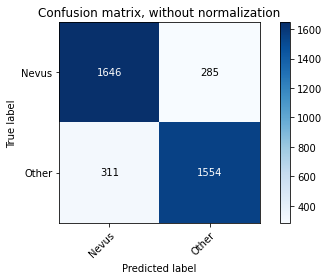

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Other'])

##### Voting (HARD)

In [ ]:
estimators = [
    ('xtree', xtree),
    ('svm', svm),
    ('xgboost', xgboost),
 ]

strt = time.time()
voter = VotingClassifier( estimators=estimators, voting = 'hard' )
transform = PowerTransformer(method='yeo-johnson', standardize=True)
voting_pipe_hard = Pipeline(steps=[('pp', transform), ('model', voter)])
# Training
voting_pipe_hard.fit(train_features, train_labels)

# Evaluation
y_pred = voting_pipe_hard.predict(val_features)  # Predictions
scores = validate_binary(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Time :', (end-strt))
print('Scores :', scores)

with open(os.path.join(save_path, 'models', 'voting_pipe_hard' + '.pkl'), 'wb') as f:
        pickle.dump(voting_pipe_hard, f)
print("Model saved..\n")

Time : 2564.2473418712616
Scores : {'confusion_matrix': array([[1653,  278],
       [ 317, 1548]]), 'accuracy': 0.8432560590094836, 'kappa': 0.6863052176260851}
Model saved..



Confusion matrix, without normalization
[[1653  278]
 [ 317 1548]]


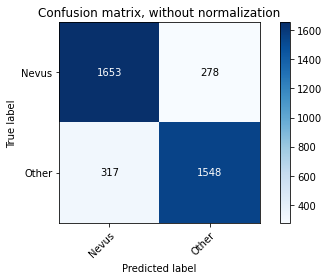

In [ ]:
plot_confusion_matrix(val_labels, y_pred, ['Nevus', 'Other'])

#### Ensembles with pretrained models (soft)

In this section we ensemble the best models that we trained in the previous sections to create averaging ensembles 

##### All Features

In [ ]:
with open(os.path.join(save_path, 'models', 'knn_a' + '.pkl'), 'rb') as file:
    knn = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xgb_a' + '.pkl'), 'rb') as file:
    xgboost = pickle.load(file)
with open(os.path.join(save_path, 'models', 'svm_a' + '.pkl'), 'rb') as file: 
    svm = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xtree_a' + '.pkl'), 'rb') as file:  
    xtree = pickle.load(file)
with open(os.path.join(save_path, 'models', 'rf_a' + '.pkl'), 'rb') as file:
    rf = pickle.load(file)

In [ ]:
xgbt_probs = xgboost.predict_proba(val_features_all) # acc = 0.842729
rf_probs = rf.predict_proba(val_features_all) # acc = 0.8282402
xtree_probs = xtree.predict_proba(val_features_all) # acc = 0.8253424
svm_probs = svm.predict_proba(val_features_all) # acc = 0.811643
knn_probs = knn.predict_proba(val_features_all) # acc = 0.77687

In [ ]:
y_probs_1 = (knn_probs + svm_probs + xtree_probs + rf_probs  + xgbt_probs)/5
y_preds_1 = np.argmax(y_probs_1, axis=1)
scores = validate_binary(y_preds_1, val_labels)
print(scores)

{'confusion_matrix': array([[1618,  313],
       [ 322, 1543]]), 'accuracy': 0.8327186512118019, 'kappa': 0.6653085321983949}


Confusion matrix, without normalization
[[1618  313]
 [ 322 1543]]


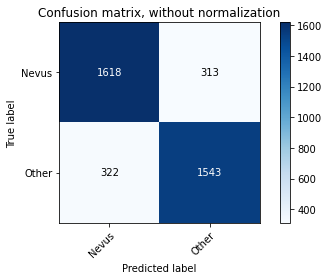

In [ ]:
plot_confusion_matrix(val_labels, y_preds_1, ['Nevus', 'Other'])

In [ ]:
y_probs_2 = (svm_probs + xtree_probs + rf_probs  + xgbt_probs)/4
y_preds_2 = np.argmax(y_probs_2, axis=1)
scores = validate_binary(y_preds_2, val_labels)
print(scores)

{'confusion_matrix': array([[1632,  299],
       [ 322, 1543]]), 'accuracy': 0.8364067439409906, 'kappa': 0.6726455580749195}


Confusion matrix, without normalization
[[1632  299]
 [ 322 1543]]


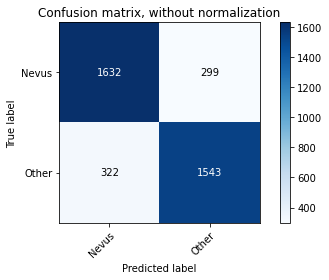

In [ ]:
plot_confusion_matrix(val_labels, y_preds_2, ['Nevus', 'Other'])

In [ ]:
y_probs_3 = (xtree_probs + rf_probs  + xgbt_probs)/3
y_preds_3 = np.argmax(y_probs_3, axis=1)
scores = validate_binary(y_preds_3, val_labels)
print(scores)

{'confusion_matrix': array([[1639,  292],
       [ 322, 1543]]), 'accuracy': 0.8382507903055848, 'kappa': 0.676314777138175}


Confusion matrix, without normalization
[[1639  292]
 [ 322 1543]]


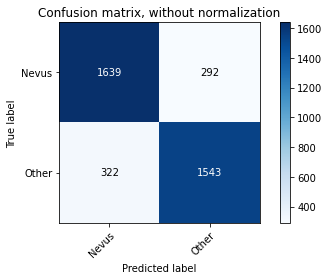

In [ ]:
plot_confusion_matrix(val_labels, y_preds_3, ['Nevus', 'Other'])

In [ ]:
y_probs_4 = (rf_probs  + xgbt_probs)/2
y_preds_4 = np.argmax(y_probs_4, axis=1)
scores = validate_binary(y_preds_4, val_labels)
print(scores)

{'confusion_matrix': array([[1637,  294],
       [ 315, 1550]]), 'accuracy': 0.8395679662802951, 'kappa': 0.6789771322843664}


Confusion matrix, without normalization
[[1637  294]
 [ 315 1550]]


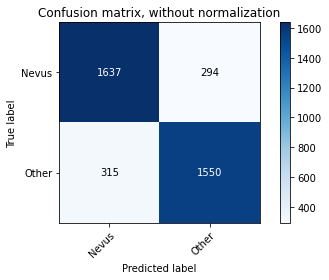

In [ ]:
plot_confusion_matrix(val_labels, y_preds_4, ['Nevus', 'Other'])

##### All + Yeo-John

In [ ]:
with open(os.path.join(save_path, 'models', 'knn_j' + '.pkl'), 'rb') as file:
    knn = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xgboost_j' + '.pkl'), 'rb') as file:
    xgboost = pickle.load(file)
with open(os.path.join(save_path, 'models', 'svm_j' + '.pkl'), 'rb') as file: 
    svm = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xtree_j' + '.pkl'), 'rb') as file:  
    xtree = pickle.load(file)
with open(os.path.join(save_path, 'models', 'rf_j' + '.pkl'), 'rb') as file:
    rf = pickle.load(file)

In [ ]:
xgbt_probs = xgboost.predict_proba(val_features_all) # acc = 0.840885
svm_probs = svm.predict_proba(val_features_all) # acc = 0.835879
xtree_probs = xtree.predict_proba(val_features_all) # acc = 0.8327186
rf_probs = rf.predict_proba(val_features_all) # acc = 0.8279768
knn_probs = knn.predict_proba(val_features_all) # acc = 0.791622

{'confusion_matrix': array([[1648,  283],
       [ 322, 1543]]), 'accuracy': 0.8406217070600632, 'kappa': 0.6810330364097168}
Confusion matrix, without normalization
[[1648  283]
 [ 322 1543]]


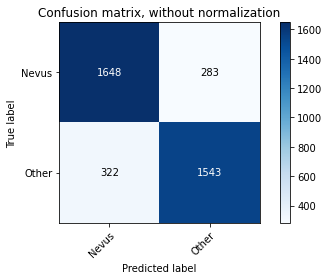

In [ ]:
y_probs_1 = ( knn_probs + rf_probs + xtree_probs + svm_probs + xgbt_probs)/5
y_preds_1 = np.argmax(y_probs_1, axis=1)
scores = validate_binary(y_preds_1, val_labels)
print(scores)
plot_confusion_matrix(val_labels, y_preds_1, ['Nevus', 'Other'])

{'confusion_matrix': array([[1650,  281],
       [ 322, 1543]]), 'accuracy': 0.8411485774499473, 'kappa': 0.6820816441951332}
Confusion matrix, without normalization
[[1650  281]
 [ 322 1543]]


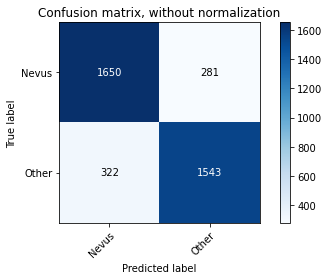

In [ ]:
y_probs_2 = (rf_probs + xtree_probs + svm_probs + xgbt_probs)/4
y_preds_2 = np.argmax(y_probs_2, axis=1)
scores = validate_binary(y_preds_2, val_labels)
print(scores)
plot_confusion_matrix(val_labels, y_preds_2, ['Nevus', 'Other'])

{'confusion_matrix': array([[1647,  284],
       [ 309, 1556]]), 'accuracy': 0.8437829293993677, 'kappa': 0.6873997705867811}
Confusion matrix, without normalization
[[1647  284]
 [ 309 1556]]


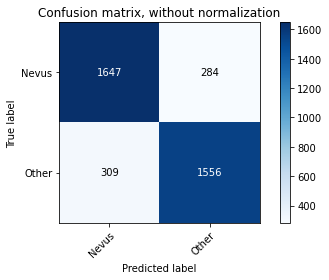

In [ ]:
y_probs_3 =  ( xtree_probs + svm_probs + xgbt_probs)/3
y_preds_3 = np.argmax(y_probs_3, axis=1)
scores = validate_binary(y_preds_3, val_labels)
print(scores)
plot_confusion_matrix(val_labels, y_preds_3, ['Nevus', 'Other'])

{'confusion_matrix': array([[1645,  286],
       [ 307, 1558]]), 'accuracy': 0.8437829293993677, 'kappa': 0.6874112306151549}
Confusion matrix, without normalization
[[1645  286]
 [ 307 1558]]


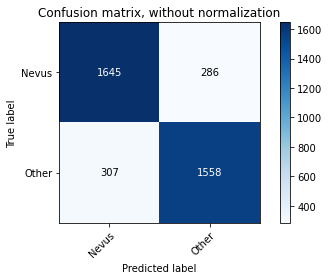

In [ ]:
y_probs_4 = (svm_probs + xgbt_probs)/2
y_preds_4 = np.argmax(y_probs_4, axis=1)
scores = validate_binary(y_preds_4, val_labels)
print(scores)
plot_confusion_matrix(val_labels, y_preds_4, ['Nevus', 'Other'])

##### Visual Yeo-John

In [ ]:
with open(os.path.join(save_path, 'models', 'knn_l' + '.pkl'), 'rb') as file:
    knn = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xgboost_l' + '.pkl'), 'rb') as file:
    xgboost = pickle.load(file)
with open(os.path.join(save_path, 'models', 'svm_l' + '.pkl'), 'rb') as file: 
    svm = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xtree_l' + '.pkl'), 'rb') as file:  
    xtree = pickle.load(file)
with open(os.path.join(save_path, 'models', 'rf_l' + '.pkl'), 'rb') as file:
    rf = pickle.load(file)

In [ ]:
knn_probs = knn.predict_proba(val_features) # acc = 0.794783
rf_probs = rf.predict_proba(val_features)  # acc = 0.8253424
xtree_probs = xtree.predict_proba(val_features) # acc = 0.8321917
svm_probs = svm.predict_proba(val_features) # acc = 0.835879
xgbt_probs = xgboost.predict_proba(val_features) # acc = 0.841675

{'confusion_matrix': array([[1637,  294],
       [ 313, 1552]]), 'accuracy': 0.8400948366701791, 'kappa': 0.6800372595459534}
Confusion matrix, without normalization
[[1637  294]
 [ 313 1552]]


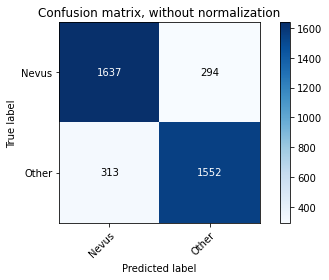

In [ ]:
y_probs_1 = (knn_probs + rf_probs + xtree_probs + svm_probs + xgbt_probs)/5
y_preds_1 = np.argmax(y_probs_1, axis=1)
scores = validate_binary(y_preds_1, val_labels)
print(scores)
plot_confusion_matrix(val_labels, y_preds_1, ['Nevus', 'Other'])

{'confusion_matrix': array([[1655,  276],
       [ 315, 1550]]), 'accuracy': 0.8443097997892518, 'kappa': 0.6884140901126324}
Confusion matrix, without normalization
[[1655  276]
 [ 315 1550]]


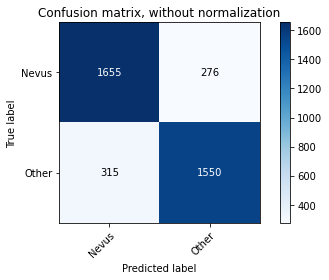

In [ ]:
y_probs_2 = (rf_probs + xtree_probs + svm_probs + xgbt_probs)/4
y_preds_2 = np.argmax(y_probs_2, axis=1)
scores = validate_binary(y_preds_2, val_labels)
print(scores)
plot_confusion_matrix(val_labels, y_preds_2, ['Nevus', 'Other'])

{'confusion_matrix': array([[1649,  282],
       [ 312, 1553]]), 'accuracy': 0.8435194942044257, 'kappa': 0.6868582697395373}
Confusion matrix, without normalization
[[1649  282]
 [ 312 1553]]


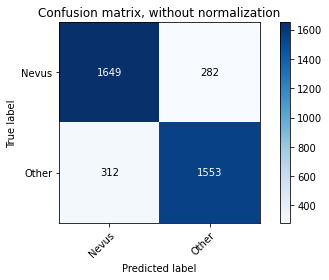

In [ ]:
y_probs_3 = (xtree_probs + svm_probs + xgbt_probs)/3
y_preds_3 = np.argmax(y_probs_3, axis=1)
scores = validate_binary(y_preds_3, val_labels)
print(scores)
plot_confusion_matrix(val_labels, y_preds_3, ['Nevus', 'Other'])

{'confusion_matrix': array([[1641,  290],
       [ 300, 1565]]), 'accuracy': 0.8445732349841939, 'kappa': 0.6890239753845129}
Confusion matrix, without normalization
[[1641  290]
 [ 300 1565]]


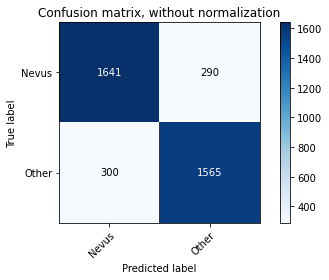

In [ ]:
y_probs_4 = (svm_probs + xgbt_probs)/2
y_preds_4 = np.argmax(y_probs_4, axis=1)
scores = validate_binary(y_preds_4, val_labels)
print(scores)
plot_confusion_matrix(val_labels, y_preds_4, ['Nevus', 'Other'])

#### Ensembles with pretrained models (hard)

In this section we ensemble the best models that we trained in the previous sections to create majority voting ensembles 

##### All Features

In [ ]:
with open(os.path.join(save_path, 'models', 'knn_a' + '.pkl'), 'rb') as file:
    knn = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xgb_a' + '.pkl'), 'rb') as file:
    xgboost = pickle.load(file)
with open(os.path.join(save_path, 'models', 'svm_a' + '.pkl'), 'rb') as file: 
    svm = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xtree_a' + '.pkl'), 'rb') as file:  
    xtree = pickle.load(file)
with open(os.path.join(save_path, 'models', 'rf_a' + '.pkl'), 'rb') as file:
    rf = pickle.load(file)

In [ ]:
xgbt_preds = xgboost.predict(val_features_all) # acc = 0.842729
rf_preds = rf.predict(val_features_all) # acc = 0.8282402
xtree_preds = xtree.predict(val_features_all) # acc = 0.8253424
svm_preds = svm.predict(val_features_all) # acc = 0.811643
knn_preds = knn.predict(val_features_all) # acc = 0.77687

{'confusion_matrix': array([[1624,  307],
       [ 334, 1531]]), 'accuracy': 0.8311380400421496, 'kappa': 0.6620903538027743}
Confusion matrix, without normalization
[[1624  307]
 [ 334 1531]]


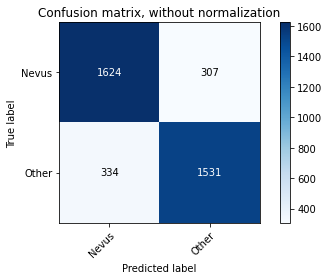

In [ ]:
preds = np.transpose(np.array([xgbt_preds, rf_preds, xtree_preds, svm_preds, knn_preds]))
labels = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in preds])
scores = validate_binary(labels, val_labels)
print(scores)
plot_confusion_matrix(val_labels, labels, ['Nevus', 'Other'])

{'confusion_matrix': array([[1598,  333],
       [ 306, 1559]]), 'accuracy': 0.8316649104320337, 'kappa': 0.6633113153439865}
Confusion matrix, without normalization
[[1598  333]
 [ 306 1559]]


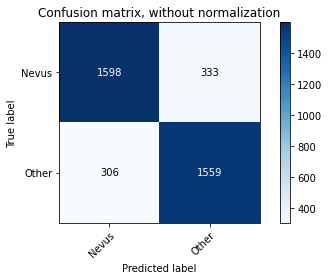

In [ ]:
preds = np.transpose(np.array([xgbt_preds, rf_preds, xtree_preds, svm_preds]))
labels = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in preds])
scores = validate_binary(labels, val_labels)
print(scores)
plot_confusion_matrix(val_labels, labels, ['Nevus', 'Other'])

{'confusion_matrix': array([[1640,  291],
       [ 348, 1517]]), 'accuracy': 0.8316649104320337, 'kappa': 0.6630520242904856}
Confusion matrix, without normalization
[[1640  291]
 [ 348 1517]]


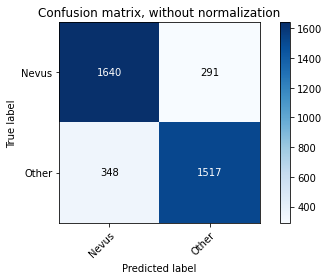

In [ ]:
preds = np.transpose(np.array([xgbt_preds, rf_preds, xtree_preds]))
labels = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in preds])
scores = validate_binary(labels, val_labels)
print(scores)
plot_confusion_matrix(val_labels, labels, ['Nevus', 'Other'])

##### All + Yeo-John

In [ ]:
with open(os.path.join(save_path, 'models', 'knn_j' + '.pkl'), 'rb') as file:
    knn = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xgboost_j' + '.pkl'), 'rb') as file:
    xgboost = pickle.load(file)
with open(os.path.join(save_path, 'models', 'svm_j' + '.pkl'), 'rb') as file: 
    svm = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xtree_j' + '.pkl'), 'rb') as file:  
    xtree = pickle.load(file)
with open(os.path.join(save_path, 'models', 'rf_j' + '.pkl'), 'rb') as file:
    rf = pickle.load(file)

In [ ]:
xgbt_preds = xgboost.predict(val_features_all) # acc = 0.840885
svm_preds = svm.predict(val_features_all) # acc = 0.835879
xtree_preds = xtree.predict(val_features_all) # acc = 0.8327186
rf_preds = rf.predict(val_features_all) # acc = 0.8279768
knn_preds = knn.predict(val_features_all) # acc = 0.791622

{'confusion_matrix': array([[1642,  289],
       [ 331, 1534]]), 'accuracy': 0.8366701791359326, 'kappa': 0.6731157753389025}
Confusion matrix, without normalization
[[1642  289]
 [ 331 1534]]


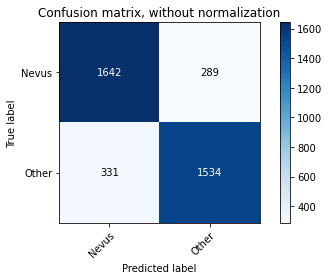

In [ ]:
preds = np.transpose(np.array([xgbt_preds, svm_preds, xtree_preds, rf_preds, knn_preds]))
labels = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in preds])
scores = validate_binary(labels, val_labels)
print(scores)
plot_confusion_matrix(val_labels, labels, ['Nevus', 'Other'])

{'confusion_matrix': array([[1610,  321],
       [ 289, 1576]]), 'accuracy': 0.839304531085353, 'kappa': 0.6786061180261556}
Confusion matrix, without normalization
[[1610  321]
 [ 289 1576]]


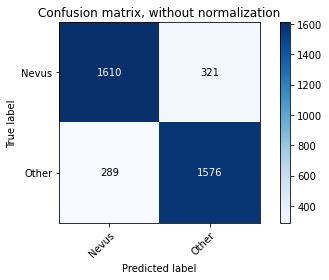

In [ ]:
preds = np.transpose(np.array([xgbt_preds, svm_preds, xtree_preds, rf_preds]))
labels = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in preds])
scores = validate_binary(labels, val_labels)
print(scores)
plot_confusion_matrix(val_labels, labels, ['Nevus', 'Other'])

{'confusion_matrix': array([[1650,  281],
       [ 315, 1550]]), 'accuracy': 0.8429926238145417, 'kappa': 0.6857924005740803}
Confusion matrix, without normalization
[[1650  281]
 [ 315 1550]]


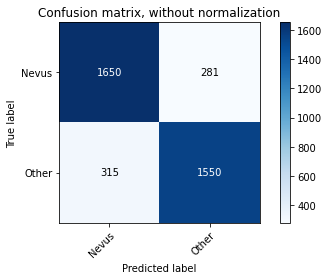

In [ ]:
preds = np.transpose(np.array([xgbt_preds, svm_preds, xtree_preds]))
labels = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in preds])
scores = validate_binary(labels, val_labels)
print(scores)
plot_confusion_matrix(val_labels, labels, ['Nevus', 'Other'])

##### Visual Yeo-John

In [ ]:
with open(os.path.join(save_path, 'models', 'knn_l' + '.pkl'), 'rb') as file:
    knn = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xgboost_l' + '.pkl'), 'rb') as file:
    xgboost = pickle.load(file)
with open(os.path.join(save_path, 'models', 'svm_l' + '.pkl'), 'rb') as file: 
    svm = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xtree_l' + '.pkl'), 'rb') as file:  
    xtree = pickle.load(file)
with open(os.path.join(save_path, 'models', 'rf_l' + '.pkl'), 'rb') as file:
    rf = pickle.load(file)

In [ ]:
knn_preds = knn.predict(val_features) # acc = 0.794783
rf_preds = rf.predict(val_features)  # acc = 0.8253424
xtree_preds = xtree.predict(val_features) # acc = 0.8321917
svm_preds = svm.predict(val_features) # acc = 0.835879
xgbt_preds = xgboost.predict(val_features) # acc = 0.841675

{'confusion_matrix': array([[1640,  291],
       [ 336, 1529]]), 'accuracy': 0.8348261327713382, 'kappa': 0.6694160557581885}
Confusion matrix, without normalization
[[1640  291]
 [ 336 1529]]


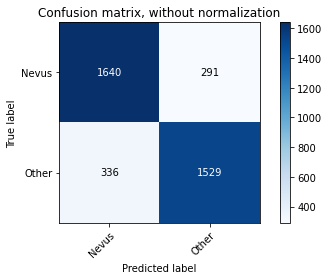

In [ ]:
preds = np.transpose(np.array([xgbt_preds, svm_preds, xtree_preds, rf_preds, knn_preds]))
labels = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in preds])
scores = validate_binary(labels, val_labels)
print(scores)
plot_confusion_matrix(val_labels, labels, ['Nevus', 'Other'])

{'confusion_matrix': array([[1604,  327],
       [ 296, 1569]]), 'accuracy': 0.8358798735511064, 'kappa': 0.6717537332698931}
Confusion matrix, without normalization
[[1604  327]
 [ 296 1569]]


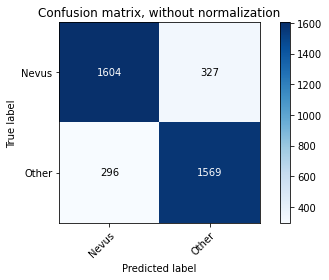

In [ ]:
preds = np.transpose(np.array([xgbt_preds, svm_preds, xtree_preds, rf_preds]))
labels = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in preds])
scores = validate_binary(labels, val_labels)
print(scores)
plot_confusion_matrix(val_labels, labels, ['Nevus', 'Other'])

{'confusion_matrix': array([[1655,  276],
       [ 316, 1549]]), 'accuracy': 0.8440463645943098, 'kappa': 0.6878840109500153}
Confusion matrix, without normalization
[[1655  276]
 [ 316 1549]]


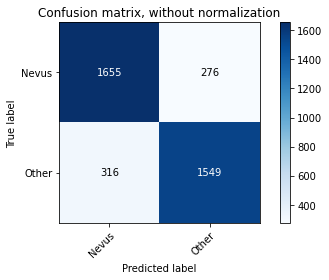

In [ ]:
preds = np.transpose(np.array([xgbt_preds, svm_preds, xtree_preds]))
labels = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in preds])
scores = validate_binary(labels, val_labels)
print(scores)
plot_confusion_matrix(val_labels, labels, ['Nevus', 'Other'])

## Visualization of the results 

In [ ]:
results_df = pd.read_csv('results_binary.csv')

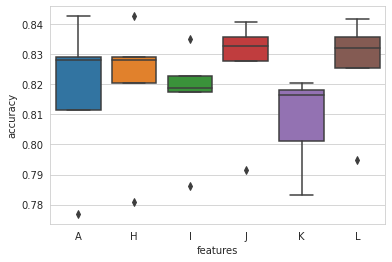

In [ ]:
sns.set_style("whitegrid") 
sns.boxplot(x = 'features', y = 'accuracy', data = results_df)

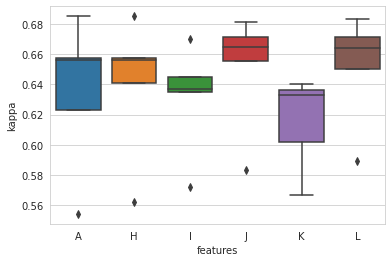

In [ ]:
sns.boxplot(x = 'features', y = 'kappa', data = results_df)

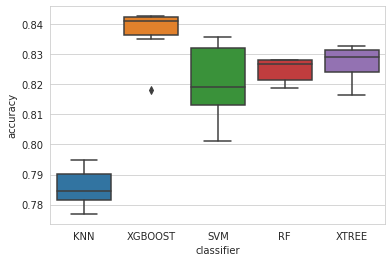

In [ ]:
sns.boxplot(x = 'classifier', y = 'accuracy', data = results_df)

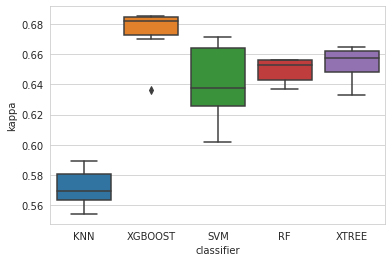

In [ ]:
sns.boxplot(x = 'classifier', y = 'kappa', data = results_df)

# Retrain best models with all data

In [ ]:
train_features_l = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, 3:], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd, 
                              train_lab_fd, 
                              train_lbp_fd, 
                              train_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])


val_features_l = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, 3:], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd, 
                            val_lab_fd, 
                            val_lbp_fd, 
                            val_haralick_fd[:, [0, 1, 2, 3, 4, 6, 9, 10]]])

all_features = np.vstack((train_features_l, val_features_l))
all_labels = np.hstack((train_labels, val_labels)).transpose()

In [ ]:
print(all_features.shape)
print(all_labels.shape)

(18991, 550)
(18991,)


Scores xgboost classifier : {'confusion_matrix': array([[9656,    0],
       [   0, 9335]]), 'accuracy': 1.0, 'kappa': 1.0}
Confusion matrix, without normalization
[[9656    0]
 [   0 9335]]


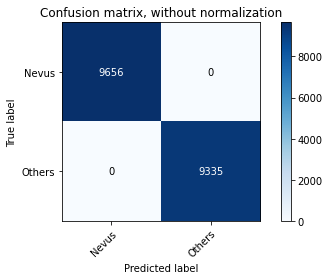

In [ ]:
xgboost = xgb.XGBClassifier(objective='binary:logistic', n_estimators=2000, max_depth=9, learning_rate=0.1)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
xgboost = Pipeline(steps=[('pp', transform), ('xgboost', xgboost)])
# Training
xgboost.fit(all_features, all_labels)
#evaluation
y_pred = xgboost.predict(all_features)  # Predictions
xgboost_scores = validate_binary(y_pred, all_labels)
print('Scores xgboost classifier :', xgboost_scores)
plot_confusion_matrix(all_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'xgboost_final' + '.pkl'), 'wb') as f:
        pickle.dump(xgboost, f)
print("Model saved..\n")

Model saved..



Scores svm classifier : {'confusion_matrix': array([[8897,  759],
       [ 625, 8710]]), 'accuracy': 0.9271233742298983, 'kappa': 0.8542398726481145}
Confusion matrix, without normalization
[[8897  759]
 [ 625 8710]]


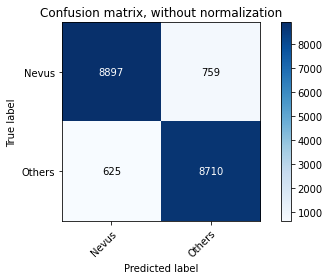

In [ ]:
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = 8)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
svm = Pipeline(steps=[('pp', transform), ('svm', svm)])
svm.fit(all_features, all_labels)

y_pred = svm.predict(all_features)  # Predictions
svm_scores = validate_binary(y_pred, all_labels)  # Compute the scores

print('Scores svm classifier :', svm_scores)
plot_confusion_matrix(all_labels, y_pred, ['Nevus', 'Others'])

In [ ]:
with open(os.path.join(save_path, 'models', 'svm_final' + '.pkl'), 'wb') as f:
        pickle.dump(svm, f)
print("Model saved..\n")

Model saved..



# Resources


***Codes***

- Vignette Cropping : https://github.com/lcambero/skin_lesion_segmentation/blob/main/segmentation.py

- Hair Removal : https://github.com/Rohit-Kundu/MFSNet/blob/main/inpaint.py
> https://plantcv.readthedocs.io/en/latest/prune/



- Color Constancy : https://www.kaggle.com/code/apacheco/shades-of-gray-color-constancy/notebook

- Image Sharpening : https://pythontic.com/image-processing/pillow/sharpen-filter

***Papers***

- Skin Lesion Classification using Metric Learning (ISIC2019_T1_final)
- Automated Digital Hair Removal by Threshold
Decomposition and Morphological Analysis (Koehoorn2015)
- Improving Dermoscopy Image Classification Using Color Constancy (barata2015)
